# Self-Driving Car Engineer Nanodegree


## Project 4: **Advanced Lane Finding** 

**The goal of the project is to develop a pipeline for identifying the lane lines and determining the position of the vehicles relative to the lines. 
The input is from images from a front-facing camera mounted at the center of the car.**

## 1. Camera calibration
Using a number of test images of a chessboard, the camera is first calibrated, i.e a distortion and rotation matrice are computed using the OpenCV library.
These distortion correction matrices are then used to undistort each image of the road captured by the camera.
An example of a calibration image of a chessboard is shown here:
    
---

<figure>
 <img src="camera_cal/calibration1.jpg" width=380 alt="Calibration image" />
 </figcaption>
</figure>

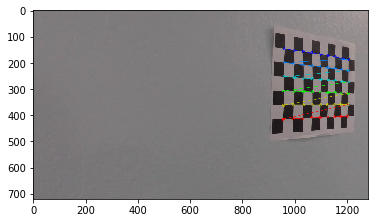

In [2]:
import glob
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


# read in and make a list of calibration images filenames
images = glob.glob('./camera_cal/calibration*.jpg')
#print(images)

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

for fname in images:
    # Read in an image
    img = cv2.imread(fname)
    plt.imshow(img)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    nx = 9 # the number of chessboard inside corners in x
    ny = 6 # the number of chessboard inside corners in y

    # prepare object points
    # initialize an array of 3D object points to 0.
    objp = np.zeros((ny*nx, 3), np.float32)
    # x,y coordinates
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) 

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, append and draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)


def calibrate(img_shape, objpoints, imgpoints):
    # A function that takes an image, object points, and image points
    # performs the camera calibration using cv2.calibrateCamera()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
    return [ret, mtx, dist, rvecs, tvecs]

def undistort(img, mtx, dist):
    # A function that performs image distortion correction and
    # returns the undistorted image using cv2.undistort()
    return cv2.undistort(img, mtx, dist, None, mtx)
    


 ### Example of a distortion corrected calibration image.

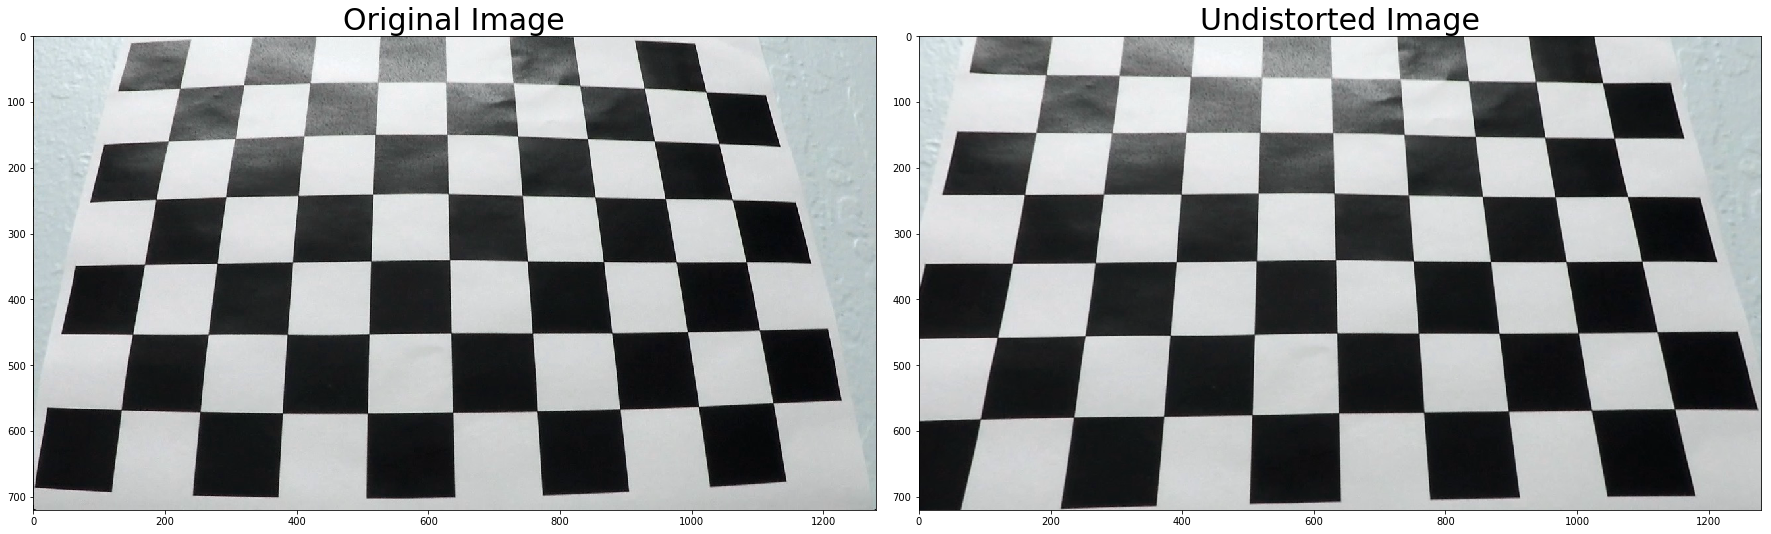

In [3]:
# Read in an image
img = cv2.imread('./camera_cal/calibration3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Calibrate based on the pre-computed object and image points
# Using the current image shape:

cal_params = calibrate(img.shape[0:2], objpoints, imgpoints)

# Undistort the image using the calibrated matrices mtx and dist
undistorted = undistort(img, cal_params[1], cal_params[2])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
_ = cv2.imwrite('./output_images/undistorted_output.jpg', undistorted[:, :, ::-1])

# Example undistorted image
road_img = mpimg.imread('./test_images/test2.jpg')
road_img_undist = undistort(road_img, cal_params[1], cal_params[2])
_ = cv2.imwrite('./output_images/undistorted_road.jpg', road_img_undist[:, :, ::-1])

## 2. Line detection pipeline
** A pipeline to find and plot lane lines on an image from a front-facing car camera. **

### Gradient and color thresholds:

In [176]:
def abs_sobel_thresh(scaled_sobel, thresh=(0, 255)):
    '''A function that applies an absolute sobel threshold.
    Parameters:
    scaled_sobel: a scaled gradient
    thresh: a tuple containing the minimum and maxium thresholds
    Returns:
    binary_output: a mask with 1's where the scaled absolute sobel gradient is within
                   the minimum and maximum thresholds
    '''
    binary_output = np.zeros_like(scaled_sobel) 
    binary_output[(scaled_sobel>thresh[0]) & (scaled_sobel<thresh[1])] = 1
    return binary_output
    

def mag_thresh(sobelx, sobely, mag_thresh=(0, 255)):
    '''A function that computes the magnitude of the gradient and applies a threshold.
    Parameters:
    sobelx: a gradient in the direction of x
    sobely: a gradient in the direction of y
    mag_thresh: a tuple containing the minimum and maxium thresholds
    
    Returns:
    binary_output: a mask with 1's where the scaled sobel gradient is within
                   the minimum and maximum thresholds
    '''
    # Calculate the magnitude of the gradient
    sobel_norm = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255*sobel_norm / np.max(sobel_norm))
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])] = 1
    return binary_output


def dir_threshold(abs_sobelx, abs_sobely, dir_thresh=(0, np.pi/2)):
    '''A function that calculates the direction of the gradient and applies a threshold.
    Parameters:
    abs_sobelx: absolute value of the gradient in the direction of x
    abs_sobely: absolute value of the gradient in the direction of y
    dir_thresh: a tuple of the minimum and maxium thresholds in radians
    
    Returns:
    binary_output: a mask with 1's where the scaled sobel gradient is within
                   the minimum and maximum thresholds
    '''
    # np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_dir)
    # Return this mask as your binary_output image
    binary_output[(grad_dir >= dir_thresh[0]) & (grad_dir <= dir_thresh[1])] = 1
    return binary_output
    

def color_threshold(img, s_thresh=(0,255)):
    # A function to separate the image in HLS channels and return
    # a binary mask when certain channel is within the min and max thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float) ## 2BGR or 2RGB depending on img
    
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    # yellow
    lower_yellow  = np.array([ 0, 100, 100])
    upper_yellow = np.array([ 50, 255, 255])
#     lower_yellow = np.array([20, 60, 60])
#     upper_yellow = np.array([38, 174, 250])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # white
#     lower_white  = np.array([20, 0, 180])
#     upper_white = np.array([255, 80, 255])
    lower_white = np.array([202,202,202])
    upper_white = np.array([255,255,255])
    mask_white = cv2.inRange(img, lower_white, upper_white)
    
    
#     r_channel = img[:,:,0]
#     r_binary = np.zeros_like(r_channel)
#     r_binary[(r_channel >= ) & (r_channel <= )] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & (l_channel > 60) & (l_channel < 200)] = 1
    
    s_binary[(mask_white == 255) | (mask_yellow == 255)] = 1 
    
    return s_binary


def detection_pipeline(img, cal_params, sobel_kernel=3):
    ''' Parameters:
    img: the input image
    cal_params: a list of parameters, pre-computed by the camera calibration function
                [ret, mtx, dist, rvecs, tvecs]
    
    '''  
    # undistort
    undist = undistort(img, cal_params[1], cal_params[2]) 
    
    #image = mpimg.imread('bridge_shadow.jpg')
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(scaled_sobelx, thresh=(40, 100))
    grady = abs_sobel_thresh(scaled_sobely, thresh=(40, 100))
    mag_binary = mag_thresh(sobelx, sobely, mag_thresh=(50, 120))
    dir_binary = dir_threshold(abs_sobelx, abs_sobely, dir_thresh=(0.7, 1.3))
    
    # combine gradient thresholds
    grad_combined = np.zeros_like(dir_binary)
    grad_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # S-channel Color threshold
    s_binary = color_threshold(undist, s_thresh=(180, 255))

    # Stack each the gradient and color binary masks
    # color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((np.zeros_like(s_binary), grad_combined, s_binary))
    
    # Combine the color and gradient binary thresholds
    combined_binary = np.zeros_like(grad_combined)
    combined_binary[(s_binary == 1) | (grad_combined == 1)] = 1
    
    return color_binary, combined_binary


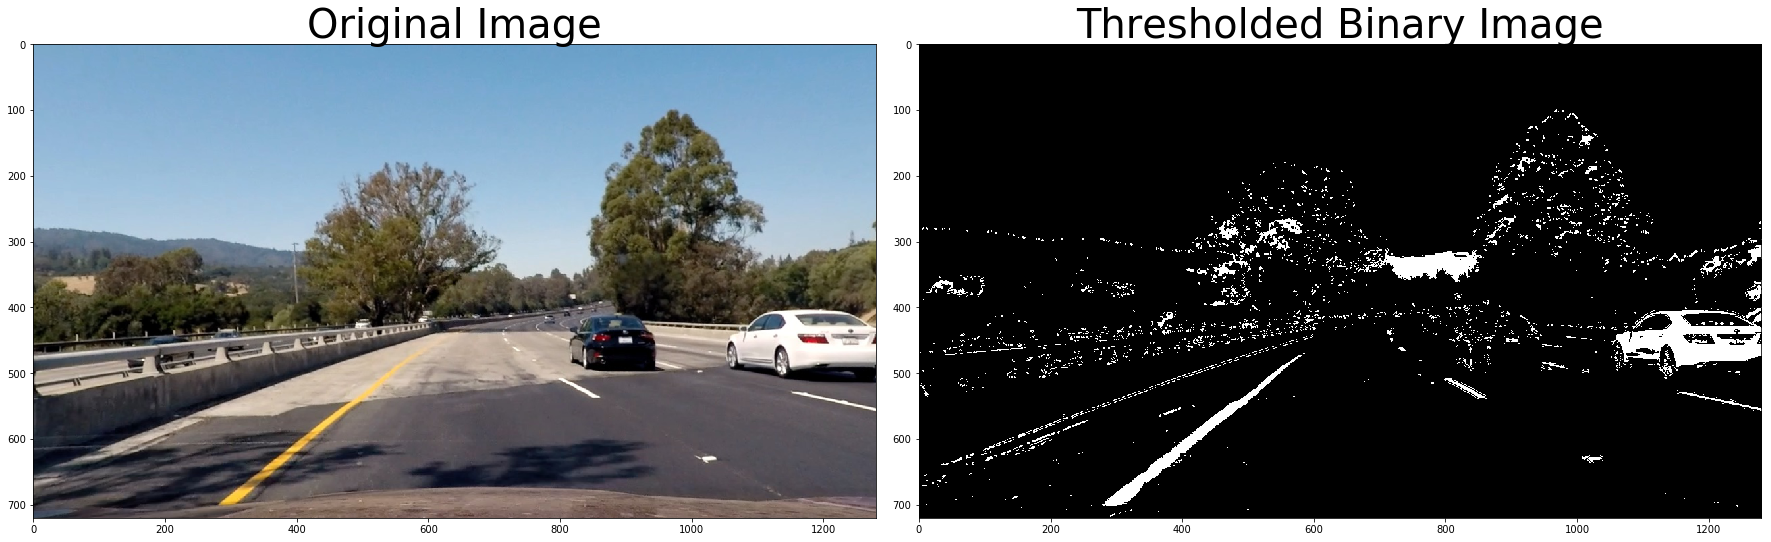

In [177]:
# Visualize output of the color and gradient threshold

image = mpimg.imread('./test_images/test4.jpg')

# Choose a Sobel kernel size
kernel_size = 7 # Choose a larger odd number to smooth gradient measurements

result = detection_pipeline(image, cal_params, sobel_kernel=kernel_size)[1]

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistort(image, cal_params[1], cal_params[2]))
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Thresholded Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Save example
result_gray = result * 255.0
_ = cv2.imwrite('./output_images/binary_road.jpg', result_gray)

### Perspective transform:

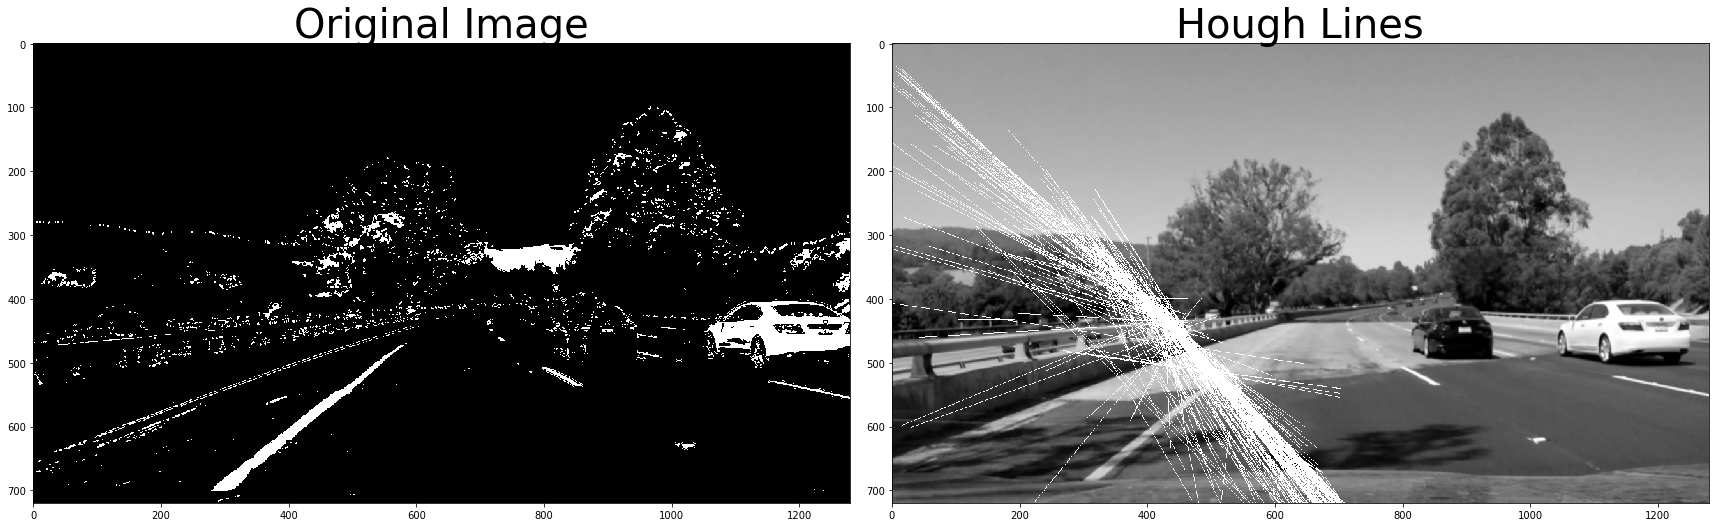

In [178]:
# Adaptive vanishing point
# Canny and Hough transform to find vanishing point

def vanishing_point(image):
    
    '''The function takes a an image as a parameter and
    finds the vanishing point using Hough transform lines'''
    
    img = np.copy(image)
    # gray scale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
    # Canny
    low_threshold = 50
    high_threshold = 150
    canny_img = cv2.Canny(img, low_threshold, high_threshold)
    #canny_img = img
   
    # Hough transform
    rho = 1
    theta = np.pi / 180
    threshold = 100
    min_line_len = 20
    max_line_gap = 30

    lines = cv2.HoughLinesP(canny_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    

    lines = lines.reshape(lines.shape[0],-1)

    # a map of all Hough lines
    voting_map = np.zeros_like(image)
    #print(voting_map.shape)
    
    color=[255, 0, 0]
    thickness=1
    for line in lines:
        # draw lines
        cv2.line(img, (line[0], line[2]), (line[1], line[3]), color, thickness)
        
        # fit lines and add to voting map

        coef = np.polyfit(line[:2], line[2:], 1) # 2 = quadratic used for Challenge 
        line_fit = np.poly1d(coef)
        x_val = np.linspace(0, image.shape[1]-1, image.shape[1]-1).astype(np.int32)
        y_val = np.polyval(line_fit, x_val).astype(np.int32)
        y_x = np.vstack((y_val,x_val))

        y_x = y_x[:, (y_x[0] > 0) & (y_x[0] < image.shape[0])]
        
        # increment cummulative total for every pixel that a line goes through
        voting_map[y_x[0], y_x[1]] += 1
    
    # the y index of the point on the map with most votes 
    # i.e. where most Hough lines cross
    vanishing_point_y = np.unravel_index(np.argmax(voting_map), dims=image.shape)[0]
    
    return voting_map, vanishing_point_y, img

result = detection_pipeline(image, cal_params, sobel_kernel=kernel_size)[1]
res = np.zeros_like(result, dtype=np.uint8)
res[result  > 0] = 1

#im = np.array(float_img * 255, dtype = np.uint8)


hough_lines = vanishing_point(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(res, cmap='gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(hough_lines[2], cmap='gray')
ax2.set_title('Hough Lines', fontsize=40)



In [146]:
# warp image to get a perspective transform

def transform_mat(img_size, vanish_point_y=None):
    # used when dynamic vanishing point determines the area of interest
    if vanish_point_y is not None:
        y_offset = vanish_point_y - img_size[1] / 2
    else:
        y_offset = 100

    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + y_offset],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + y_offset]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])


#     src = np.float32([(220, 719), (550, 480), (730, 480), (1060, 719)])
#     dst = np.float32([(220, 719), (220, 180), (1060, 180), (1060, 719)])
    # best
#     src = np.float32([(200, 720), (580, 480), (720, 480), (1080, 720)])
#     dst = np.float32([(280, 720), (400, 190), (920, 190), (960, 720)])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


def img_warp(img, M):
    # A function to transform the perspective into "birds eye view"
    # Parameters: M: a transformation matrix calculated with cv2.getPerspectiveTransform
    
    img_size = (img.shape[1], img.shape[0])   
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

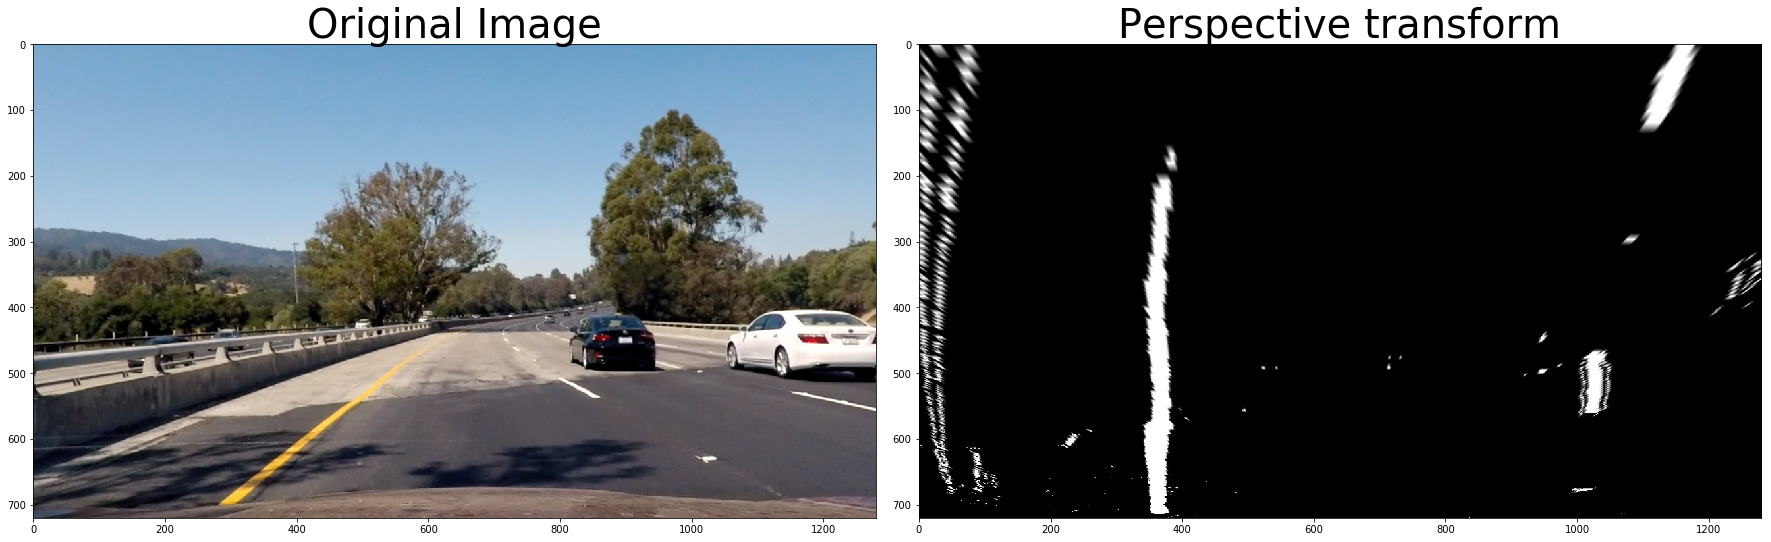

In [179]:
# Visualize output of the perspective transform

#image = mpimg.imread('./test_images/test6.jpg')

# Choose a Sobel kernel size
kernel_size = 5 # Choose a larger odd number to smooth gradient measurements

result = detection_pipeline(image, cal_params, sobel_kernel=kernel_size)[1]

# for vanishing_point calculations only
# res = np.zeros_like(result, dtype=np.uint8)
# res[result  > 0] = 1
vanish_p = vanishing_point(image)[1]


t_map = transform_mat(result.shape[::-1])[0]
result = img_warp(result, t_map)

undist = undistort(image, cal_params[1], cal_params[2])
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Perspective transform', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Save example
result_gray_warp = result * 255.0
_ = cv2.imwrite('./output_images/warped_straight_lines.jpg', result_gray_warp)

### Line detection using sliding windows:

In [126]:
def line_detect(img):
    # Parameters:
    # img: a warped binary image with detected line pixels
    binary_warped = img

    # Take a histogram of the bottom half of the image
    #print(binary_warped.shape)
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,], axis=0)
    #plt.plot(histogram)
    # Visualization of windows:
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    #print(histogram.shape)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ### Visualize
    # Generate x and y values for plotting
    
    # Fitted line x and y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, leftx, rightx, lefty, righty, left_fitx, right_fitx

In [48]:
def roi(img, left_f, right_f):
    ''' Detect lane with a region of interest from a line detection from previous image
    Parameters:
     img: a binary warped image
     left_fit, right fit: a polynomial fit of the left and right lane lines, 
                            computed from a previous image.
    '''
    binary_warped = img
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_f[0]*(nonzeroy**2) + left_f[1]*nonzeroy + left_f[2] - margin)) & (nonzerox < (left_f[0]*(nonzeroy**2) + left_f[1]*nonzeroy + left_f[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_f[0]*(nonzeroy**2) + right_f[1]*nonzeroy + right_f[2] - margin)) & (nonzerox < (right_f[0]*(nonzeroy**2) + right_f[1]*nonzeroy + right_f[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, leftx, rightx, lefty, righty, left_fitx, right_fitx

In [49]:
def plot_fitted(binary_warped, left_fitx, right_fitx):
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    plt.imshow(out_img)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

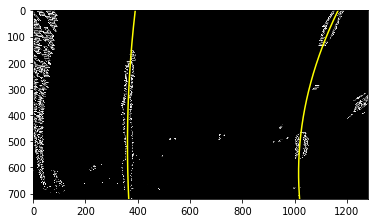

In [180]:
binary_warped = result # binary warped image (B/W)
plot_fitted(binary_warped, *line_detect(binary_warped)[-2:])

In [138]:
## Measuring curvature radius

def curvature(img, left_fit, right_fit, left_x, right_x, left_y, right_y, left_fitx, right_fitx):
    binary_warped = img
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_y*ym_per_pix, left_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_y*ym_per_pix, right_x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    
    return left_curverad, right_curverad


In [139]:
line_params = line_detect(result)
curvature(result, *line_params)

(1422.2969643734536, 419.2448391577023)

In [206]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [] #np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # the curvature of the last successful fit
        self.recent_curv = None
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    # Sanity check
    def line_err(self, new_fit):
        if len(self.current_fit) < 5:
            return True
        sq_err = (new_fit - self.current_fit[-1])**2
        err = np.sqrt(sq_err)
        
        
        if np.any(err[:2] > 0.5):
            
#             print('new_fit: ', new_fit )
#             print('current fit:', self.current_fit[-1] ) 
#             print('Line error: ', err[0:2])
            return False
        else: 
            return True
        
        
# 'Sanity-checks' (NOT USED)
def check_curvature(left_curvature, right_curvature, threshold=2500):
    #print('Curvature check: ', np.abs(right_curvature - left_curvature) < threshold, left_curvature - right_curvature)
    return np.abs(right_curvature - left_curvature) < threshold


def check_separation(left_line, right_line, sep_threshold=150, lane_width=720 , lane_threshold=150):

    # horizontal separation, check if lines are approximately parallel 
    # threshold in pixels
    sep_top = right_line[0] - left_line[0]
    sep_bottom = right_line[-1] - left_line[-1]
    sep = np.abs(sep_top - sep_bottom) < sep_threshold
    #print('Check_separation: top vs bottom', sep_top, sep_bottom)
    
    # check if distance between lines is approximately right distance
    forms_lane = np.abs(sep_top - lane_width) < lane_threshold and np.abs(sep_bottom - lane_width) < lane_threshold
    #print('Forms lane: ', forms_lane)
    return sep and forms_lane

In [154]:
def img_unwarp(orig_img, bin_warped, Minv, left_fit, right_fit, offset=None, side=None, curvature=None): # unwarp and project the lines onto the original image
    
    #print('Left and right fit inside img_unwrap: ', left_fit,right_fit)
    
    ploty = np.linspace(0, bin_warped.shape[0]-1, bin_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    
    # annotate image with Curvature and vehicle position data
    cv2.putText(result, 'Vehicle is {0:.2f} meters {1:s} of Center'.format(offset, side), (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (256,256,256), thickness=2)
    cv2.putText(result, 'Radius of Curvature: {:.2f} meters'.format(curvature), (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (256,256,256), thickness=2)
    return result

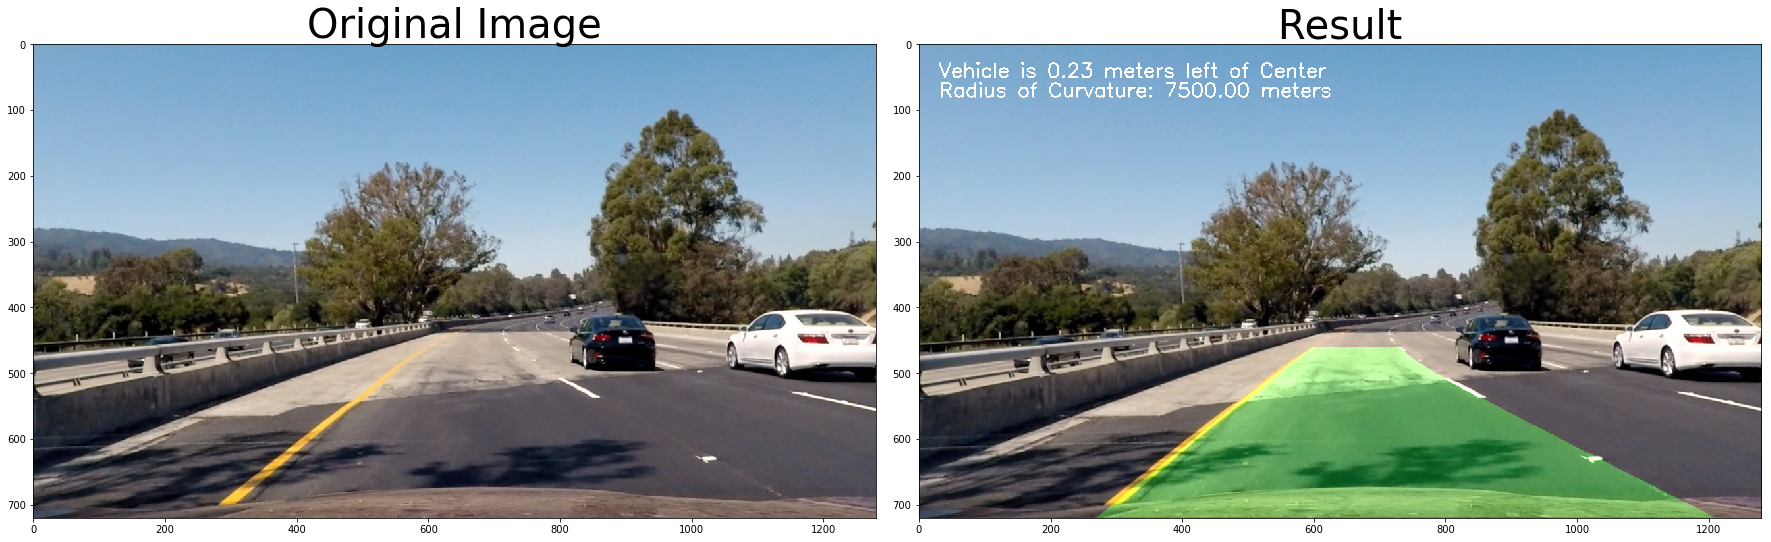

In [142]:
t_invmap = transform_mat((1280, 720))[1]
res = img_unwarp(undist, binary_warped, t_invmap, line_params[0], line_params[1], 0.23, "left", 7500)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(res)
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Save example
_ = cv2.imwrite('./output_images/example_output.jpg', res[:, :, ::-1])

In [207]:
# transformation matrices
t_map = transform_mat((1280,720))[0]
t_invmap = transform_mat((1280,720))[1]

left_line = Line()
right_line = Line()
kernel_size = 7
n_detections = 0
err_detections = 0

# image processing pipeline 
def process_image(img, cal_params, n_avg = 20):
    global n_detections
    global err_detections
    n_detections += 2
    undistorted = undistort(img, cal_params[1], cal_params[2])
    
    result = detection_pipeline(img, cal_params, sobel_kernel=kernel_size)[1]
    
    warped_binary = img_warp(result, t_map)
    
    if left_line.detected and right_line.detected:
        # use region of interest search
        #print('Before Roi search: ', left_line.current_fit[-1], right_line.current_fit[-1])
        line_params = roi(warped_binary, left_line.current_fit[-1], right_line.current_fit[-1])
        #print('AFTER Roi search: ', line_params[0], line_params[1])
        #plot_fitted(warped_binary, *line_params[-2:])
    else:
        # left_fit, right_fit, leftx, rightx, lefty, righty, left_fitx, right_fitx
        line_params = line_detect(warped_binary) 
    
    # get curvature radius for both lines in meters
    left_curve, right_curve = curvature(warped_binary, *line_params)
    if left_line.radius_of_curvature == None:
        left_line.radius_of_curvature = left_curve
    if right_line.radius_of_curvature == None:
        right_line.radius_of_curvature = right_curve

    
    # the position of the camera in the image
    camera_center = binary_warped.shape[1] // 2
    
    # sanity checks: 
    # similar curvature
    # separated by approximately the right distance horizontally
    # roughly parallel

    # "sanity checks"
    # if check_separation(*line_params[-2:]) and check_curvature(left_curve, right_curve): # left_line.check_curvature(left_curve) and left_line.check_slope(line_params[0]) and check_separation(line_params[2], line_params[3]):
            
    # left line
    if left_line.line_err(line_params[0]):
        #print('LEFT PASS')    
        # found a fit, update lines parameters
        left_line.detected = True
        
        # append x values to x values array of the last n fits of the line
        left_line.recent_xfitted.append(line_params[6])
        left_line.current_fit.append(line_params[0])
        left_line.radius_of_curvature = left_curve
        
        left_line.base_pos = camera_center - line_params[6][-1] # [line_params[4]==np.max(line_params[4])]
        left_line.diffs = left_line.current_fit[-1] - line_params[0] # difference in fit coefficients between last and new fits #np.array([0,0,0], dtype='float') 
        left_line.allx = line_params[2] # x values for detected line pixels
        left_line.ally = line_params[4]# y values for detected line pixels
        # print(type(left_line.current_fit))
        ### left_line.current_fit.append(line_params[0])
        # average x values of the fitted line over the last n iterations
        left_line.bestx =  np.mean(left_line.recent_xfitted[-n_avg:], axis=0)    
        # polynomial coefficients averaged over the last n iterations
        #print(left_line.current_fit)
        left_line.best_fit = np.mean(left_line.current_fit[-n_avg:], axis=0)    
    else:
        left_line.detected = False
        err_detections += 1
        #print('NO LEFT PASS')
        
    # right line   
    #if True: #right_line.check_curvature(right_curve) and right_line.check_slope(line_params[1]) and check_separation(line_params[2], line_params[3]):
    if right_line.line_err(line_params[1]):
        #print('RIGHT PASS')
  
        right_line.detected = True
        
        # append x values to x values array of the last n fits of the line
        right_line.recent_xfitted.append(line_params[7])
        right_line.current_fit.append(line_params[1])
        right_line.radius_of_curvature = right_curve
        right_line.base_pos = line_params[7][-1] - camera_center #[line_params[5] == np.max(line_params[5])]
        right_line.diffs =  right_line.current_fit[-1] - line_params[1] # difference in fit coefficients between last and new fits
        right_line.allx =  line_params[3]# x values for detected line pixels
        right_line.ally = line_params[5]# y values for detected line pixels
        ###right_line.current_fit.append(line_params[1])
        # average x values of the fitted line over the last n iterations
        right_line.bestx =  np.mean(right_line.recent_xfitted[-n_avg:], axis=0)    
        # polynomial coefficients averaged over the last n iterations
        right_line.best_fit = np.mean(right_line.current_fit[-n_avg:], axis=0)
                
        #print('Left and Right Fit: ', left_line.current_fit, right_line.current_fit)
          
    else:
        # no lines detected in the image, use previous fit
        #left_line.detected = False
        right_line.detected = False
        err_detections += 1

        # line_params =  previous fitted parameters
        #print('NO LEFT PASS')
        #print('NO RIGHT PASS')
    
    # arguments to img_unwarp to display radius and distance data on the image
    side = None
    vehicle_offset_px = (right_line.recent_xfitted[-1][-1] + left_line.recent_xfitted[-1][-1]) / 2 - camera_center 
    
    if vehicle_offset_px >= 0:
        side = 'Right'
    else: 
        side = 'Left'
    
    xm_per_pix = 3.7/1200 # meters per pixel in x dimension
    vehicle_offset_m = vehicle_offset_px * xm_per_pix
    # average radius of the 2 curves. To be passed to the img_unwrap() function.
    radius = (left_line.radius_of_curvature + right_line.radius_of_curvature) / 2
        
   
    if left_line.best_fit == None or right_line.best_fit == None:
        return undistorted
    unwarped = img_unwarp(undistorted, warped_binary, t_invmap, left_line.best_fit, right_line.best_fit, offset=np.abs(vehicle_offset_m), side=side, curvature=radius)

    print('Accuracy: ', 1 - err_detections/ n_detections)
    return unwarped


In [160]:
# Video

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [208]:
# NOTE: The output you return should be a color image (3 channel) for processing video below
vid_output = './output_images/project_video_output.mp4'


clip1 = VideoFileClip("./project_video.mp4")#.subclip(18,25)
white_clip = clip1.fl_image(lambda x : process_image(x, cal_params)) #NOTE: this function expects color images!!
%time (white_clip.write_videofile(vid_output, audio=False))

Accuracy:  1.0
[MoviePy] >>>> Building video ./output_images/project_video_output.mp4
[MoviePy] Writing video ./output_images/project_video_output.mp4



  0%|          | 1/1261 [00:00<07:53,  2.66it/s]

Accuracy:  1.0



  0%|          | 2/1261 [00:00<08:02,  2.61it/s]

Accuracy:  1.0



  0%|          | 3/1261 [00:01<08:01,  2.61it/s]

Accuracy:  1.0



  0%|          | 4/1261 [00:01<07:58,  2.63it/s]

Accuracy:  1.0



  0%|          | 5/1261 [00:01<07:51,  2.67it/s]

Accuracy:  1.0



  0%|          | 6/1261 [00:02<07:46,  2.69it/s]

Accuracy:  1.0



  1%|          | 7/1261 [00:02<07:48,  2.67it/s]

Accuracy:  1.0



  1%|          | 8/1261 [00:03<07:46,  2.69it/s]

Accuracy:  1.0



  1%|          | 9/1261 [00:03<07:50,  2.66it/s]

Accuracy:  1.0



  1%|          | 10/1261 [00:03<07:51,  2.66it/s]

Accuracy:  1.0



  1%|          | 11/1261 [00:04<07:42,  2.70it/s]

Accuracy:  1.0



  1%|          | 12/1261 [00:04<07:42,  2.70it/s]

Accuracy:  1.0



  1%|          | 13/1261 [00:04<07:36,  2.73it/s]

Accuracy:  1.0



  1%|          | 14/1261 [00:05<07:33,  2.75it/s]

Accuracy:  1.0



  1%|          | 15/1261 [00:05<07:30,  2.76it/s]

Accuracy:  1.0



  1%|▏         | 16/1261 [00:05<07:30,  2.76it/s]

Accuracy:  1.0



  1%|▏         | 17/1261 [00:06<07:29,  2.77it/s]

Accuracy:  1.0



  1%|▏         | 18/1261 [00:06<07:35,  2.73it/s]

Accuracy:  1.0



  2%|▏         | 19/1261 [00:07<07:39,  2.70it/s]

Accuracy:  1.0



  2%|▏         | 20/1261 [00:07<07:36,  2.72it/s]

Accuracy:  1.0



  2%|▏         | 21/1261 [00:07<07:35,  2.72it/s]

Accuracy:  1.0



  2%|▏         | 22/1261 [00:08<07:42,  2.68it/s]

Accuracy:  1.0



  2%|▏         | 23/1261 [00:08<07:53,  2.62it/s]

Accuracy:  1.0



  2%|▏         | 24/1261 [00:08<07:47,  2.65it/s]

Accuracy:  1.0



  2%|▏         | 25/1261 [00:09<07:51,  2.62it/s]

Accuracy:  1.0



  2%|▏         | 26/1261 [00:09<08:04,  2.55it/s]

Accuracy:  1.0



  2%|▏         | 27/1261 [00:10<08:02,  2.56it/s]

Accuracy:  1.0



  2%|▏         | 28/1261 [00:10<07:51,  2.62it/s]

Accuracy:  1.0



  2%|▏         | 29/1261 [00:10<07:39,  2.68it/s]

Accuracy:  1.0



  2%|▏         | 30/1261 [00:11<07:45,  2.64it/s]

Accuracy:  1.0



  2%|▏         | 31/1261 [00:11<07:50,  2.61it/s]

Accuracy:  1.0



  3%|▎         | 32/1261 [00:12<08:03,  2.54it/s]

Accuracy:  1.0



  3%|▎         | 33/1261 [00:12<08:16,  2.47it/s]

Accuracy:  1.0



  3%|▎         | 34/1261 [00:12<08:24,  2.43it/s]

Accuracy:  1.0



  3%|▎         | 35/1261 [00:13<08:20,  2.45it/s]

Accuracy:  1.0



  3%|▎         | 36/1261 [00:13<08:03,  2.54it/s]

Accuracy:  1.0



  3%|▎         | 37/1261 [00:14<07:56,  2.57it/s]

Accuracy:  1.0



  3%|▎         | 38/1261 [00:14<07:58,  2.56it/s]

Accuracy:  1.0



  3%|▎         | 39/1261 [00:14<08:05,  2.52it/s]

Accuracy:  1.0



  3%|▎         | 40/1261 [00:15<08:02,  2.53it/s]

Accuracy:  1.0



  3%|▎         | 41/1261 [00:15<07:46,  2.61it/s]

Accuracy:  1.0



  3%|▎         | 42/1261 [00:15<07:35,  2.68it/s]

Accuracy:  1.0



  3%|▎         | 43/1261 [00:16<07:59,  2.54it/s]

Accuracy:  1.0



  3%|▎         | 44/1261 [00:16<08:05,  2.51it/s]

Accuracy:  1.0



  4%|▎         | 45/1261 [00:17<07:56,  2.55it/s]

Accuracy:  1.0



  4%|▎         | 46/1261 [00:17<07:45,  2.61it/s]

Accuracy:  1.0



  4%|▎         | 47/1261 [00:18<08:18,  2.44it/s]

Accuracy:  1.0



  4%|▍         | 48/1261 [00:18<09:11,  2.20it/s]

Accuracy:  1.0



  4%|▍         | 49/1261 [00:19<09:21,  2.16it/s]

Accuracy:  1.0



  4%|▍         | 50/1261 [00:19<09:20,  2.16it/s]

Accuracy:  1.0



  4%|▍         | 51/1261 [00:19<08:40,  2.32it/s]

Accuracy:  1.0



  4%|▍         | 52/1261 [00:20<08:31,  2.36it/s]

Accuracy:  1.0



  4%|▍         | 53/1261 [00:20<08:46,  2.30it/s]

Accuracy:  1.0



  4%|▍         | 54/1261 [00:21<08:57,  2.25it/s]

Accuracy:  1.0



  4%|▍         | 55/1261 [00:21<08:29,  2.37it/s]

Accuracy:  1.0



  4%|▍         | 56/1261 [00:21<08:11,  2.45it/s]

Accuracy:  1.0



  5%|▍         | 57/1261 [00:22<07:51,  2.55it/s]

Accuracy:  1.0



  5%|▍         | 58/1261 [00:22<07:43,  2.59it/s]

Accuracy:  1.0



  5%|▍         | 59/1261 [00:23<07:39,  2.61it/s]

Accuracy:  1.0



  5%|▍         | 60/1261 [00:23<07:41,  2.60it/s]

Accuracy:  1.0



  5%|▍         | 61/1261 [00:23<07:32,  2.65it/s]

Accuracy:  1.0



  5%|▍         | 62/1261 [00:24<07:43,  2.59it/s]

Accuracy:  1.0



  5%|▍         | 63/1261 [00:24<07:42,  2.59it/s]

Accuracy:  1.0



  5%|▌         | 64/1261 [00:24<07:48,  2.56it/s]

Accuracy:  1.0



  5%|▌         | 65/1261 [00:25<07:50,  2.54it/s]

Accuracy:  1.0



  5%|▌         | 66/1261 [00:25<07:34,  2.63it/s]

Accuracy:  1.0



  5%|▌         | 67/1261 [00:26<07:23,  2.69it/s]

Accuracy:  1.0



  5%|▌         | 68/1261 [00:26<07:20,  2.71it/s]

Accuracy:  1.0



  5%|▌         | 69/1261 [00:26<07:13,  2.75it/s]

Accuracy:  1.0



  6%|▌         | 70/1261 [00:27<07:15,  2.73it/s]

Accuracy:  1.0



  6%|▌         | 71/1261 [00:27<07:09,  2.77it/s]

Accuracy:  1.0



  6%|▌         | 72/1261 [00:27<07:17,  2.72it/s]

Accuracy:  1.0



  6%|▌         | 73/1261 [00:28<07:20,  2.70it/s]

Accuracy:  1.0



  6%|▌         | 74/1261 [00:28<07:12,  2.74it/s]

Accuracy:  1.0



  6%|▌         | 75/1261 [00:29<07:16,  2.72it/s]

Accuracy:  1.0



  6%|▌         | 76/1261 [00:29<07:20,  2.69it/s]

Accuracy:  1.0



  6%|▌         | 77/1261 [00:29<07:13,  2.73it/s]

Accuracy:  1.0



  6%|▌         | 78/1261 [00:30<07:14,  2.72it/s]

Accuracy:  1.0



  6%|▋         | 79/1261 [00:30<07:26,  2.65it/s]

Accuracy:  1.0



  6%|▋         | 80/1261 [00:30<07:26,  2.65it/s]

Accuracy:  1.0



  6%|▋         | 81/1261 [00:31<07:40,  2.56it/s]

Accuracy:  1.0



  7%|▋         | 82/1261 [00:31<07:36,  2.58it/s]

Accuracy:  1.0



  7%|▋         | 83/1261 [00:32<07:38,  2.57it/s]

Accuracy:  1.0



  7%|▋         | 84/1261 [00:32<07:46,  2.52it/s]

Accuracy:  1.0



  7%|▋         | 85/1261 [00:32<07:30,  2.61it/s]

Accuracy:  1.0



  7%|▋         | 86/1261 [00:33<07:30,  2.61it/s]

Accuracy:  1.0



  7%|▋         | 87/1261 [00:33<07:30,  2.61it/s]

Accuracy:  1.0



  7%|▋         | 88/1261 [00:33<07:20,  2.66it/s]

Accuracy:  1.0



  7%|▋         | 89/1261 [00:34<07:10,  2.72it/s]

Accuracy:  1.0



  7%|▋         | 90/1261 [00:34<07:03,  2.76it/s]

Accuracy:  1.0



  7%|▋         | 91/1261 [00:35<07:06,  2.74it/s]

Accuracy:  1.0



  7%|▋         | 92/1261 [00:35<07:03,  2.76it/s]

Accuracy:  1.0



  7%|▋         | 93/1261 [00:35<06:59,  2.78it/s]

Accuracy:  1.0



  7%|▋         | 94/1261 [00:36<06:57,  2.79it/s]

Accuracy:  1.0



  8%|▊         | 95/1261 [00:36<07:06,  2.73it/s]

Accuracy:  1.0



  8%|▊         | 96/1261 [00:36<07:03,  2.75it/s]

Accuracy:  1.0



  8%|▊         | 97/1261 [00:37<07:08,  2.72it/s]

Accuracy:  1.0



  8%|▊         | 98/1261 [00:37<07:02,  2.75it/s]

Accuracy:  1.0



  8%|▊         | 99/1261 [00:37<07:07,  2.72it/s]

Accuracy:  1.0



  8%|▊         | 100/1261 [00:38<07:11,  2.69it/s]

Accuracy:  1.0



  8%|▊         | 101/1261 [00:38<07:09,  2.70it/s]

Accuracy:  1.0



  8%|▊         | 102/1261 [00:39<07:08,  2.71it/s]

Accuracy:  1.0



  8%|▊         | 103/1261 [00:39<07:07,  2.71it/s]

Accuracy:  1.0



  8%|▊         | 104/1261 [00:39<07:03,  2.73it/s]

Accuracy:  1.0



  8%|▊         | 105/1261 [00:40<06:57,  2.77it/s]

Accuracy:  1.0



  8%|▊         | 106/1261 [00:40<06:54,  2.79it/s]

Accuracy:  1.0



  8%|▊         | 107/1261 [00:40<06:58,  2.76it/s]

Accuracy:  1.0



  9%|▊         | 108/1261 [00:41<06:56,  2.77it/s]

Accuracy:  1.0



  9%|▊         | 109/1261 [00:41<07:20,  2.62it/s]

Accuracy:  1.0



  9%|▊         | 110/1261 [00:42<07:43,  2.48it/s]

Accuracy:  1.0



  9%|▉         | 111/1261 [00:42<07:41,  2.49it/s]

Accuracy:  1.0



  9%|▉         | 112/1261 [00:42<07:27,  2.57it/s]

Accuracy:  1.0



  9%|▉         | 113/1261 [00:43<07:14,  2.64it/s]

Accuracy:  1.0



  9%|▉         | 114/1261 [00:43<07:05,  2.70it/s]

Accuracy:  1.0



  9%|▉         | 115/1261 [00:43<07:12,  2.65it/s]

Accuracy:  1.0



  9%|▉         | 116/1261 [00:44<07:06,  2.69it/s]

Accuracy:  1.0



  9%|▉         | 117/1261 [00:44<06:57,  2.74it/s]

Accuracy:  1.0



  9%|▉         | 118/1261 [00:45<06:57,  2.74it/s]

Accuracy:  1.0



  9%|▉         | 119/1261 [00:45<06:58,  2.73it/s]

Accuracy:  1.0



 10%|▉         | 120/1261 [00:45<06:52,  2.76it/s]

Accuracy:  1.0



 10%|▉         | 121/1261 [00:46<06:50,  2.78it/s]

Accuracy:  1.0



 10%|▉         | 122/1261 [00:46<06:52,  2.76it/s]

Accuracy:  1.0



 10%|▉         | 123/1261 [00:46<07:00,  2.70it/s]

Accuracy:  1.0



 10%|▉         | 124/1261 [00:47<06:55,  2.74it/s]

Accuracy:  1.0



 10%|▉         | 125/1261 [00:47<07:27,  2.54it/s]

Accuracy:  1.0



 10%|▉         | 126/1261 [00:48<08:04,  2.34it/s]

Accuracy:  1.0



 10%|█         | 127/1261 [00:48<07:46,  2.43it/s]

Accuracy:  1.0



 10%|█         | 128/1261 [00:48<07:34,  2.49it/s]

Accuracy:  1.0



 10%|█         | 129/1261 [00:49<07:20,  2.57it/s]

Accuracy:  1.0



 10%|█         | 130/1261 [00:49<07:06,  2.65it/s]

Accuracy:  1.0



 10%|█         | 131/1261 [00:50<07:12,  2.61it/s]

Accuracy:  1.0



 10%|█         | 132/1261 [00:50<07:16,  2.59it/s]

Accuracy:  1.0



 11%|█         | 133/1261 [00:50<07:22,  2.55it/s]

Accuracy:  1.0



 11%|█         | 134/1261 [00:51<07:28,  2.51it/s]

Accuracy:  1.0



 11%|█         | 135/1261 [00:51<07:35,  2.47it/s]

Accuracy:  1.0



 11%|█         | 136/1261 [00:52<07:20,  2.56it/s]

Accuracy:  1.0



 11%|█         | 137/1261 [00:52<07:07,  2.63it/s]

Accuracy:  1.0



 11%|█         | 138/1261 [00:52<06:56,  2.70it/s]

Accuracy:  1.0



 11%|█         | 139/1261 [00:53<06:57,  2.69it/s]

Accuracy:  1.0



 11%|█         | 140/1261 [00:53<07:19,  2.55it/s]

Accuracy:  1.0



 11%|█         | 141/1261 [00:53<07:11,  2.60it/s]

Accuracy:  1.0



 11%|█▏        | 142/1261 [00:54<07:13,  2.58it/s]

Accuracy:  1.0



 11%|█▏        | 143/1261 [00:54<07:10,  2.60it/s]

Accuracy:  1.0



 11%|█▏        | 144/1261 [00:55<07:01,  2.65it/s]

Accuracy:  1.0



 11%|█▏        | 145/1261 [00:55<06:57,  2.68it/s]

Accuracy:  1.0



 12%|█▏        | 146/1261 [00:55<07:20,  2.53it/s]

Accuracy:  1.0



 12%|█▏        | 147/1261 [00:56<07:17,  2.55it/s]

Accuracy:  1.0



 12%|█▏        | 148/1261 [00:56<07:04,  2.62it/s]

Accuracy:  1.0



 12%|█▏        | 149/1261 [00:57<07:26,  2.49it/s]

Accuracy:  1.0



 12%|█▏        | 150/1261 [00:57<07:50,  2.36it/s]

Accuracy:  1.0



 12%|█▏        | 151/1261 [00:58<08:02,  2.30it/s]

Accuracy:  1.0



 12%|█▏        | 152/1261 [00:58<08:37,  2.14it/s]

Accuracy:  1.0



 12%|█▏        | 153/1261 [00:58<08:09,  2.26it/s]

Accuracy:  1.0



 12%|█▏        | 154/1261 [00:59<07:47,  2.37it/s]

Accuracy:  1.0



 12%|█▏        | 155/1261 [00:59<07:36,  2.42it/s]

Accuracy:  1.0



 12%|█▏        | 156/1261 [01:00<07:20,  2.51it/s]

Accuracy:  1.0



 12%|█▏        | 157/1261 [01:00<07:12,  2.55it/s]

Accuracy:  1.0



 13%|█▎        | 158/1261 [01:00<07:08,  2.58it/s]

Accuracy:  1.0



 13%|█▎        | 159/1261 [01:01<07:02,  2.61it/s]

Accuracy:  1.0



 13%|█▎        | 160/1261 [01:01<07:07,  2.57it/s]

Accuracy:  1.0



 13%|█▎        | 161/1261 [01:02<07:30,  2.44it/s]

Accuracy:  1.0



 13%|█▎        | 162/1261 [01:02<07:55,  2.31it/s]

Accuracy:  1.0



 13%|█▎        | 163/1261 [01:02<07:44,  2.37it/s]

Accuracy:  1.0



 13%|█▎        | 164/1261 [01:03<07:30,  2.44it/s]

Accuracy:  1.0



 13%|█▎        | 165/1261 [01:03<07:18,  2.50it/s]

Accuracy:  1.0



 13%|█▎        | 166/1261 [01:04<07:05,  2.57it/s]

Accuracy:  1.0



 13%|█▎        | 167/1261 [01:04<06:59,  2.61it/s]

Accuracy:  1.0



 13%|█▎        | 168/1261 [01:04<06:53,  2.64it/s]

Accuracy:  1.0



 13%|█▎        | 169/1261 [01:05<06:59,  2.60it/s]

Accuracy:  1.0



 13%|█▎        | 170/1261 [01:05<06:57,  2.61it/s]

Accuracy:  1.0



 14%|█▎        | 171/1261 [01:05<06:57,  2.61it/s]

Accuracy:  1.0



 14%|█▎        | 172/1261 [01:06<06:49,  2.66it/s]

Accuracy:  1.0



 14%|█▎        | 173/1261 [01:06<06:41,  2.71it/s]

Accuracy:  1.0



 14%|█▍        | 174/1261 [01:07<06:40,  2.71it/s]

Accuracy:  1.0



 14%|█▍        | 175/1261 [01:07<07:24,  2.44it/s]

Accuracy:  1.0



 14%|█▍        | 176/1261 [01:07<07:25,  2.43it/s]

Accuracy:  1.0



 14%|█▍        | 177/1261 [01:08<07:33,  2.39it/s]

Accuracy:  1.0



 14%|█▍        | 178/1261 [01:08<07:30,  2.40it/s]

Accuracy:  1.0



 14%|█▍        | 179/1261 [01:09<07:32,  2.39it/s]

Accuracy:  1.0



 14%|█▍        | 180/1261 [01:09<07:26,  2.42it/s]

Accuracy:  1.0



 14%|█▍        | 181/1261 [01:09<07:10,  2.51it/s]

Accuracy:  1.0



 14%|█▍        | 182/1261 [01:10<07:00,  2.56it/s]

Accuracy:  1.0



 15%|█▍        | 183/1261 [01:10<06:59,  2.57it/s]

Accuracy:  1.0



 15%|█▍        | 184/1261 [01:11<07:01,  2.56it/s]

Accuracy:  1.0



 15%|█▍        | 185/1261 [01:11<06:55,  2.59it/s]

Accuracy:  1.0



 15%|█▍        | 186/1261 [01:11<06:48,  2.63it/s]

Accuracy:  1.0



 15%|█▍        | 187/1261 [01:12<06:54,  2.59it/s]

Accuracy:  1.0



 15%|█▍        | 188/1261 [01:12<07:04,  2.53it/s]

Accuracy:  1.0



 15%|█▍        | 189/1261 [01:13<06:56,  2.57it/s]

Accuracy:  1.0



 15%|█▌        | 190/1261 [01:13<06:46,  2.63it/s]

Accuracy:  1.0



 15%|█▌        | 191/1261 [01:13<06:45,  2.64it/s]

Accuracy:  1.0



 15%|█▌        | 192/1261 [01:14<06:46,  2.63it/s]

Accuracy:  1.0



 15%|█▌        | 193/1261 [01:14<06:38,  2.68it/s]

Accuracy:  1.0



 15%|█▌        | 194/1261 [01:14<06:35,  2.70it/s]

Accuracy:  1.0



 15%|█▌        | 195/1261 [01:15<06:34,  2.71it/s]

Accuracy:  1.0



 16%|█▌        | 196/1261 [01:15<06:35,  2.69it/s]

Accuracy:  1.0



 16%|█▌        | 197/1261 [01:16<06:34,  2.70it/s]

Accuracy:  1.0



 16%|█▌        | 198/1261 [01:16<06:32,  2.71it/s]

Accuracy:  1.0



 16%|█▌        | 199/1261 [01:16<06:43,  2.63it/s]

Accuracy:  1.0



 16%|█▌        | 200/1261 [01:17<06:58,  2.53it/s]

Accuracy:  1.0



 16%|█▌        | 201/1261 [01:17<06:56,  2.54it/s]

Accuracy:  1.0



 16%|█▌        | 202/1261 [01:18<06:59,  2.52it/s]

Accuracy:  1.0



 16%|█▌        | 203/1261 [01:18<06:53,  2.56it/s]

Accuracy:  1.0



 16%|█▌        | 204/1261 [01:18<07:02,  2.50it/s]

Accuracy:  1.0



 16%|█▋        | 205/1261 [01:19<06:58,  2.52it/s]

Accuracy:  1.0



 16%|█▋        | 206/1261 [01:19<06:50,  2.57it/s]

Accuracy:  1.0



 16%|█▋        | 207/1261 [01:19<06:46,  2.60it/s]

Accuracy:  1.0



 16%|█▋        | 208/1261 [01:20<06:44,  2.60it/s]

Accuracy:  1.0



 17%|█▋        | 209/1261 [01:20<06:41,  2.62it/s]

Accuracy:  1.0



 17%|█▋        | 210/1261 [01:21<07:13,  2.42it/s]

Accuracy:  1.0



 17%|█▋        | 211/1261 [01:21<07:18,  2.39it/s]

Accuracy:  1.0



 17%|█▋        | 212/1261 [01:21<06:58,  2.51it/s]

Accuracy:  1.0



 17%|█▋        | 213/1261 [01:22<06:48,  2.57it/s]

Accuracy:  1.0



 17%|█▋        | 214/1261 [01:22<06:37,  2.64it/s]

Accuracy:  1.0



 17%|█▋        | 215/1261 [01:23<06:35,  2.64it/s]

Accuracy:  1.0



 17%|█▋        | 216/1261 [01:23<06:32,  2.66it/s]

Accuracy:  1.0



 17%|█▋        | 217/1261 [01:23<06:25,  2.71it/s]

Accuracy:  1.0



 17%|█▋        | 218/1261 [01:24<06:26,  2.70it/s]

Accuracy:  1.0



 17%|█▋        | 219/1261 [01:24<06:30,  2.67it/s]

Accuracy:  1.0



 17%|█▋        | 220/1261 [01:24<06:30,  2.67it/s]

Accuracy:  1.0



 18%|█▊        | 221/1261 [01:25<06:33,  2.64it/s]

Accuracy:  1.0



 18%|█▊        | 222/1261 [01:25<06:35,  2.63it/s]

Accuracy:  1.0



 18%|█▊        | 223/1261 [01:26<06:35,  2.63it/s]

Accuracy:  1.0



 18%|█▊        | 224/1261 [01:26<06:35,  2.62it/s]

Accuracy:  1.0



 18%|█▊        | 225/1261 [01:26<06:31,  2.65it/s]

Accuracy:  1.0



 18%|█▊        | 226/1261 [01:27<06:30,  2.65it/s]

Accuracy:  1.0



 18%|█▊        | 227/1261 [01:27<06:28,  2.66it/s]

Accuracy:  1.0



 18%|█▊        | 228/1261 [01:27<06:32,  2.63it/s]

Accuracy:  1.0



 18%|█▊        | 229/1261 [01:28<06:50,  2.51it/s]

Accuracy:  1.0



 18%|█▊        | 230/1261 [01:28<07:21,  2.34it/s]

Accuracy:  1.0



 18%|█▊        | 231/1261 [01:29<07:26,  2.30it/s]

Accuracy:  1.0



 18%|█▊        | 232/1261 [01:29<07:06,  2.41it/s]

Accuracy:  1.0



 18%|█▊        | 233/1261 [01:30<06:49,  2.51it/s]

Accuracy:  1.0



 19%|█▊        | 234/1261 [01:30<06:40,  2.56it/s]

Accuracy:  1.0



 19%|█▊        | 235/1261 [01:30<06:36,  2.59it/s]

Accuracy:  1.0



 19%|█▊        | 236/1261 [01:31<06:30,  2.62it/s]

Accuracy:  1.0



 19%|█▉        | 237/1261 [01:31<06:34,  2.60it/s]

Accuracy:  1.0



 19%|█▉        | 238/1261 [01:31<06:27,  2.64it/s]

Accuracy:  1.0



 19%|█▉        | 239/1261 [01:32<06:30,  2.62it/s]

Accuracy:  1.0



 19%|█▉        | 240/1261 [01:32<06:24,  2.65it/s]

Accuracy:  1.0



 19%|█▉        | 241/1261 [01:33<06:21,  2.67it/s]

Accuracy:  1.0



 19%|█▉        | 242/1261 [01:33<06:23,  2.65it/s]

Accuracy:  1.0



 19%|█▉        | 243/1261 [01:33<06:30,  2.61it/s]

Accuracy:  1.0



 19%|█▉        | 244/1261 [01:34<06:25,  2.64it/s]

Accuracy:  1.0



 19%|█▉        | 245/1261 [01:34<06:25,  2.64it/s]

Accuracy:  1.0



 20%|█▉        | 246/1261 [01:35<06:55,  2.45it/s]

Accuracy:  1.0



 20%|█▉        | 247/1261 [01:35<07:06,  2.38it/s]

Accuracy:  1.0



 20%|█▉        | 248/1261 [01:35<06:54,  2.44it/s]

Accuracy:  1.0



 20%|█▉        | 249/1261 [01:36<06:39,  2.53it/s]

Accuracy:  1.0



 20%|█▉        | 250/1261 [01:36<06:33,  2.57it/s]

Accuracy:  1.0



 20%|█▉        | 251/1261 [01:37<06:30,  2.59it/s]

Accuracy:  1.0



 20%|█▉        | 252/1261 [01:37<06:28,  2.60it/s]

Accuracy:  1.0



 20%|██        | 253/1261 [01:37<06:25,  2.61it/s]

Accuracy:  1.0



 20%|██        | 254/1261 [01:38<06:21,  2.64it/s]

Accuracy:  1.0



 20%|██        | 255/1261 [01:38<06:22,  2.63it/s]

Accuracy:  1.0



 20%|██        | 256/1261 [01:38<06:20,  2.64it/s]

Accuracy:  1.0



 20%|██        | 257/1261 [01:39<06:18,  2.66it/s]

Accuracy:  1.0



 20%|██        | 258/1261 [01:39<06:15,  2.67it/s]

Accuracy:  1.0



 21%|██        | 259/1261 [01:40<06:25,  2.60it/s]

Accuracy:  1.0



 21%|██        | 260/1261 [01:40<06:18,  2.65it/s]

Accuracy:  1.0



 21%|██        | 261/1261 [01:40<06:20,  2.62it/s]

Accuracy:  1.0



 21%|██        | 262/1261 [01:41<06:28,  2.57it/s]

Accuracy:  1.0



 21%|██        | 263/1261 [01:41<06:38,  2.50it/s]

Accuracy:  1.0



 21%|██        | 264/1261 [01:42<06:35,  2.52it/s]

Accuracy:  1.0



 21%|██        | 265/1261 [01:42<06:40,  2.49it/s]

Accuracy:  1.0



 21%|██        | 266/1261 [01:42<06:31,  2.54it/s]

Accuracy:  1.0



 21%|██        | 267/1261 [01:43<06:26,  2.57it/s]

Accuracy:  1.0



 21%|██▏       | 268/1261 [01:43<06:18,  2.62it/s]

Accuracy:  1.0



 21%|██▏       | 269/1261 [01:43<06:11,  2.67it/s]

Accuracy:  1.0



 21%|██▏       | 270/1261 [01:44<06:04,  2.72it/s]

Accuracy:  1.0



 21%|██▏       | 271/1261 [01:44<06:06,  2.70it/s]

Accuracy:  1.0



 22%|██▏       | 272/1261 [01:45<06:19,  2.60it/s]

Accuracy:  1.0



 22%|██▏       | 273/1261 [01:45<06:21,  2.59it/s]

Accuracy:  1.0



 22%|██▏       | 274/1261 [01:45<06:19,  2.60it/s]

Accuracy:  1.0



 22%|██▏       | 275/1261 [01:46<06:17,  2.61it/s]

Accuracy:  1.0



 22%|██▏       | 276/1261 [01:46<06:38,  2.47it/s]

Accuracy:  1.0



 22%|██▏       | 277/1261 [01:47<06:38,  2.47it/s]

Accuracy:  1.0



 22%|██▏       | 278/1261 [01:47<06:24,  2.56it/s]

Accuracy:  1.0



 22%|██▏       | 279/1261 [01:47<06:26,  2.54it/s]

Accuracy:  1.0



 22%|██▏       | 280/1261 [01:48<06:27,  2.53it/s]

Accuracy:  1.0



 22%|██▏       | 281/1261 [01:48<06:13,  2.63it/s]

Accuracy:  1.0



 22%|██▏       | 282/1261 [01:48<06:10,  2.64it/s]

Accuracy:  1.0



 22%|██▏       | 283/1261 [01:49<06:06,  2.67it/s]

Accuracy:  1.0



 23%|██▎       | 284/1261 [01:49<06:07,  2.66it/s]

Accuracy:  1.0



 23%|██▎       | 285/1261 [01:50<06:03,  2.69it/s]

Accuracy:  1.0



 23%|██▎       | 286/1261 [01:50<05:56,  2.73it/s]

Accuracy:  1.0



 23%|██▎       | 287/1261 [01:50<06:00,  2.70it/s]

Accuracy:  1.0



 23%|██▎       | 288/1261 [01:51<06:05,  2.66it/s]

Accuracy:  1.0



 23%|██▎       | 289/1261 [01:51<06:05,  2.66it/s]

Accuracy:  1.0



 23%|██▎       | 290/1261 [01:51<06:02,  2.68it/s]

Accuracy:  1.0



 23%|██▎       | 291/1261 [01:52<06:09,  2.63it/s]

Accuracy:  1.0



 23%|██▎       | 292/1261 [01:52<06:09,  2.62it/s]

Accuracy:  1.0



 23%|██▎       | 293/1261 [01:53<06:15,  2.58it/s]

Accuracy:  1.0



 23%|██▎       | 294/1261 [01:53<06:16,  2.57it/s]

Accuracy:  1.0



 23%|██▎       | 295/1261 [01:53<06:08,  2.62it/s]

Accuracy:  1.0



 23%|██▎       | 296/1261 [01:54<06:04,  2.65it/s]

Accuracy:  1.0



 24%|██▎       | 297/1261 [01:54<05:58,  2.69it/s]

Accuracy:  1.0



 24%|██▎       | 298/1261 [01:54<05:56,  2.70it/s]

Accuracy:  1.0



 24%|██▎       | 299/1261 [01:55<05:50,  2.74it/s]

Accuracy:  1.0



 24%|██▍       | 300/1261 [01:55<05:49,  2.75it/s]

Accuracy:  1.0



 24%|██▍       | 301/1261 [01:56<05:47,  2.76it/s]

Accuracy:  1.0



 24%|██▍       | 302/1261 [01:56<05:50,  2.74it/s]

Accuracy:  1.0



 24%|██▍       | 303/1261 [01:56<05:54,  2.70it/s]

Accuracy:  1.0



 24%|██▍       | 304/1261 [01:57<05:49,  2.74it/s]

Accuracy:  1.0



 24%|██▍       | 305/1261 [01:57<05:46,  2.76it/s]

Accuracy:  1.0



 24%|██▍       | 306/1261 [01:57<05:48,  2.74it/s]

Accuracy:  1.0



 24%|██▍       | 307/1261 [01:58<05:47,  2.75it/s]

Accuracy:  1.0



 24%|██▍       | 308/1261 [01:58<05:43,  2.77it/s]

Accuracy:  1.0



 25%|██▍       | 309/1261 [01:58<05:40,  2.80it/s]

Accuracy:  1.0



 25%|██▍       | 310/1261 [01:59<05:47,  2.74it/s]

Accuracy:  1.0



 25%|██▍       | 311/1261 [01:59<05:43,  2.77it/s]

Accuracy:  1.0



 25%|██▍       | 312/1261 [02:00<05:42,  2.77it/s]

Accuracy:  1.0



 25%|██▍       | 313/1261 [02:00<05:41,  2.77it/s]

Accuracy:  1.0



 25%|██▍       | 314/1261 [02:00<05:45,  2.74it/s]

Accuracy:  1.0



 25%|██▍       | 315/1261 [02:01<05:44,  2.75it/s]

Accuracy:  1.0



 25%|██▌       | 316/1261 [02:01<05:40,  2.77it/s]

Accuracy:  1.0



 25%|██▌       | 317/1261 [02:01<05:44,  2.74it/s]

Accuracy:  1.0



 25%|██▌       | 318/1261 [02:02<05:44,  2.74it/s]

Accuracy:  1.0



 25%|██▌       | 319/1261 [02:02<05:43,  2.75it/s]

Accuracy:  1.0



 25%|██▌       | 320/1261 [02:02<05:39,  2.77it/s]

Accuracy:  1.0



 25%|██▌       | 321/1261 [02:03<05:38,  2.78it/s]

Accuracy:  1.0



 26%|██▌       | 322/1261 [02:03<05:44,  2.73it/s]

Accuracy:  1.0



 26%|██▌       | 323/1261 [02:04<05:42,  2.74it/s]

Accuracy:  1.0



 26%|██▌       | 324/1261 [02:04<05:37,  2.77it/s]

Accuracy:  1.0



 26%|██▌       | 325/1261 [02:04<05:35,  2.79it/s]

Accuracy:  1.0



 26%|██▌       | 326/1261 [02:05<05:42,  2.73it/s]

Accuracy:  1.0



 26%|██▌       | 327/1261 [02:05<05:39,  2.75it/s]

Accuracy:  1.0



 26%|██▌       | 328/1261 [02:05<05:37,  2.76it/s]

Accuracy:  1.0



 26%|██▌       | 329/1261 [02:06<05:37,  2.76it/s]

Accuracy:  1.0



 26%|██▌       | 330/1261 [02:06<05:40,  2.73it/s]

Accuracy:  1.0



 26%|██▌       | 331/1261 [02:06<05:46,  2.69it/s]

Accuracy:  1.0



 26%|██▋       | 332/1261 [02:07<05:41,  2.72it/s]

Accuracy:  1.0



 26%|██▋       | 333/1261 [02:07<05:40,  2.72it/s]

Accuracy:  1.0



 26%|██▋       | 334/1261 [02:08<05:40,  2.72it/s]

Accuracy:  1.0



 27%|██▋       | 335/1261 [02:08<05:40,  2.72it/s]

Accuracy:  1.0



 27%|██▋       | 336/1261 [02:08<05:37,  2.74it/s]

Accuracy:  1.0



 27%|██▋       | 337/1261 [02:09<05:35,  2.75it/s]

Accuracy:  1.0



 27%|██▋       | 338/1261 [02:09<05:45,  2.67it/s]

Accuracy:  1.0



 27%|██▋       | 339/1261 [02:09<05:41,  2.70it/s]

Accuracy:  1.0



 27%|██▋       | 340/1261 [02:10<05:36,  2.73it/s]

Accuracy:  1.0



 27%|██▋       | 341/1261 [02:10<05:31,  2.77it/s]

Accuracy:  1.0



 27%|██▋       | 342/1261 [02:11<05:47,  2.64it/s]

Accuracy:  1.0



 27%|██▋       | 343/1261 [02:11<05:59,  2.55it/s]

Accuracy:  1.0



 27%|██▋       | 344/1261 [02:11<05:52,  2.60it/s]

Accuracy:  1.0



 27%|██▋       | 345/1261 [02:12<05:44,  2.66it/s]

Accuracy:  1.0



 27%|██▋       | 346/1261 [02:12<05:49,  2.62it/s]

Accuracy:  1.0



 28%|██▊       | 347/1261 [02:13<05:57,  2.56it/s]

Accuracy:  1.0



 28%|██▊       | 348/1261 [02:13<05:56,  2.56it/s]

Accuracy:  1.0



 28%|██▊       | 349/1261 [02:13<05:53,  2.58it/s]

Accuracy:  1.0



 28%|██▊       | 350/1261 [02:14<06:08,  2.47it/s]

Accuracy:  1.0



 28%|██▊       | 351/1261 [02:14<05:56,  2.55it/s]

Accuracy:  1.0



 28%|██▊       | 352/1261 [02:14<05:49,  2.60it/s]

Accuracy:  1.0



 28%|██▊       | 353/1261 [02:15<05:49,  2.60it/s]

Accuracy:  1.0



 28%|██▊       | 354/1261 [02:15<05:59,  2.52it/s]

Accuracy:  1.0



 28%|██▊       | 355/1261 [02:16<05:59,  2.52it/s]

Accuracy:  1.0



 28%|██▊       | 356/1261 [02:16<05:59,  2.52it/s]

Accuracy:  1.0



 28%|██▊       | 357/1261 [02:16<06:02,  2.49it/s]

Accuracy:  1.0



 28%|██▊       | 358/1261 [02:17<06:04,  2.48it/s]

Accuracy:  1.0



 28%|██▊       | 359/1261 [02:17<05:58,  2.51it/s]

Accuracy:  1.0



 29%|██▊       | 360/1261 [02:18<05:51,  2.57it/s]

Accuracy:  1.0



 29%|██▊       | 361/1261 [02:18<06:05,  2.46it/s]

Accuracy:  1.0



 29%|██▊       | 362/1261 [02:19<06:16,  2.39it/s]

Accuracy:  1.0



 29%|██▉       | 363/1261 [02:19<06:22,  2.35it/s]

Accuracy:  1.0



 29%|██▉       | 364/1261 [02:19<06:15,  2.39it/s]

Accuracy:  1.0



 29%|██▉       | 365/1261 [02:20<06:03,  2.47it/s]

Accuracy:  1.0



 29%|██▉       | 366/1261 [02:20<06:17,  2.37it/s]

Accuracy:  1.0



 29%|██▉       | 367/1261 [02:21<06:30,  2.29it/s]

Accuracy:  1.0



 29%|██▉       | 368/1261 [02:21<06:31,  2.28it/s]

Accuracy:  1.0



 29%|██▉       | 369/1261 [02:22<06:19,  2.35it/s]

Accuracy:  1.0



 29%|██▉       | 370/1261 [02:22<06:29,  2.29it/s]

Accuracy:  1.0



 29%|██▉       | 371/1261 [02:22<06:08,  2.41it/s]

Accuracy:  1.0



 30%|██▉       | 372/1261 [02:23<05:50,  2.54it/s]

Accuracy:  1.0



 30%|██▉       | 373/1261 [02:23<05:38,  2.63it/s]

Accuracy:  1.0



 30%|██▉       | 374/1261 [02:23<05:38,  2.62it/s]

Accuracy:  1.0



 30%|██▉       | 375/1261 [02:24<06:05,  2.42it/s]

Accuracy:  1.0



 30%|██▉       | 376/1261 [02:24<05:48,  2.54it/s]

Accuracy:  1.0



 30%|██▉       | 377/1261 [02:25<05:36,  2.63it/s]

Accuracy:  1.0



 30%|██▉       | 378/1261 [02:25<05:30,  2.67it/s]

Accuracy:  1.0



 30%|███       | 379/1261 [02:25<05:24,  2.72it/s]

Accuracy:  1.0



 30%|███       | 380/1261 [02:26<05:19,  2.76it/s]

Accuracy:  1.0



 30%|███       | 381/1261 [02:26<05:17,  2.77it/s]

Accuracy:  1.0



 30%|███       | 382/1261 [02:26<05:16,  2.77it/s]

Accuracy:  1.0



 30%|███       | 383/1261 [02:27<05:14,  2.79it/s]

Accuracy:  1.0



 30%|███       | 384/1261 [02:27<05:35,  2.61it/s]

Accuracy:  1.0



 31%|███       | 385/1261 [02:28<05:48,  2.51it/s]

Accuracy:  1.0



 31%|███       | 386/1261 [02:28<05:40,  2.57it/s]

Accuracy:  1.0



 31%|███       | 387/1261 [02:28<05:30,  2.65it/s]

Accuracy:  1.0



 31%|███       | 388/1261 [02:29<05:21,  2.71it/s]

Accuracy:  1.0



 31%|███       | 389/1261 [02:29<05:15,  2.76it/s]

Accuracy:  1.0



 31%|███       | 390/1261 [02:29<05:13,  2.78it/s]

Accuracy:  1.0



 31%|███       | 391/1261 [02:30<05:12,  2.78it/s]

Accuracy:  1.0



 31%|███       | 392/1261 [02:30<05:09,  2.81it/s]

Accuracy:  1.0



 31%|███       | 393/1261 [02:30<05:11,  2.78it/s]

Accuracy:  1.0



 31%|███       | 394/1261 [02:31<05:12,  2.78it/s]

Accuracy:  1.0



 31%|███▏      | 395/1261 [02:31<05:11,  2.78it/s]

Accuracy:  1.0



 31%|███▏      | 396/1261 [02:32<05:33,  2.59it/s]

Accuracy:  1.0



 31%|███▏      | 397/1261 [02:32<05:51,  2.46it/s]

Accuracy:  1.0



 32%|███▏      | 398/1261 [02:33<06:00,  2.39it/s]

Accuracy:  1.0



 32%|███▏      | 399/1261 [02:33<05:50,  2.46it/s]

Accuracy:  1.0



 32%|███▏      | 400/1261 [02:33<05:34,  2.58it/s]

Accuracy:  1.0



 32%|███▏      | 401/1261 [02:34<05:23,  2.66it/s]

Accuracy:  1.0



 32%|███▏      | 402/1261 [02:34<05:18,  2.69it/s]

Accuracy:  1.0



 32%|███▏      | 403/1261 [02:34<05:14,  2.73it/s]

Accuracy:  1.0



 32%|███▏      | 404/1261 [02:35<05:25,  2.63it/s]

Accuracy:  1.0



 32%|███▏      | 405/1261 [02:35<05:16,  2.70it/s]

Accuracy:  1.0



 32%|███▏      | 406/1261 [02:35<05:13,  2.72it/s]

Accuracy:  1.0



 32%|███▏      | 407/1261 [02:36<05:29,  2.59it/s]

Accuracy:  1.0



 32%|███▏      | 408/1261 [02:36<05:48,  2.45it/s]

Accuracy:  1.0



 32%|███▏      | 409/1261 [02:37<05:41,  2.50it/s]

Accuracy:  1.0



 33%|███▎      | 410/1261 [02:37<05:32,  2.56it/s]

Accuracy:  1.0



 33%|███▎      | 411/1261 [02:37<05:21,  2.64it/s]

Accuracy:  1.0



 33%|███▎      | 412/1261 [02:38<05:21,  2.64it/s]

Accuracy:  1.0



 33%|███▎      | 413/1261 [02:38<05:51,  2.41it/s]

Accuracy:  1.0



 33%|███▎      | 414/1261 [02:39<05:40,  2.48it/s]

Accuracy:  1.0



 33%|███▎      | 415/1261 [02:39<05:33,  2.53it/s]

Accuracy:  1.0



 33%|███▎      | 416/1261 [02:39<05:21,  2.63it/s]

Accuracy:  1.0



 33%|███▎      | 417/1261 [02:40<05:17,  2.66it/s]

Accuracy:  1.0



 33%|███▎      | 418/1261 [02:40<05:19,  2.64it/s]

Accuracy:  1.0



 33%|███▎      | 419/1261 [02:40<05:11,  2.70it/s]

Accuracy:  1.0



 33%|███▎      | 420/1261 [02:41<05:07,  2.74it/s]

Accuracy:  1.0



 33%|███▎      | 421/1261 [02:41<05:08,  2.72it/s]

Accuracy:  1.0



 33%|███▎      | 422/1261 [02:42<05:09,  2.71it/s]

Accuracy:  1.0



 34%|███▎      | 423/1261 [02:42<05:06,  2.73it/s]

Accuracy:  1.0



 34%|███▎      | 424/1261 [02:42<05:35,  2.50it/s]

Accuracy:  1.0



 34%|███▎      | 425/1261 [02:43<05:37,  2.48it/s]

Accuracy:  1.0



 34%|███▍      | 426/1261 [02:43<05:29,  2.54it/s]

Accuracy:  1.0



 34%|███▍      | 427/1261 [02:44<05:17,  2.62it/s]

Accuracy:  1.0



 34%|███▍      | 428/1261 [02:44<05:08,  2.70it/s]

Accuracy:  1.0



 34%|███▍      | 429/1261 [02:44<05:37,  2.47it/s]

Accuracy:  1.0



 34%|███▍      | 430/1261 [02:45<05:25,  2.55it/s]

Accuracy:  1.0



 34%|███▍      | 431/1261 [02:45<05:16,  2.62it/s]

Accuracy:  1.0



 34%|███▍      | 432/1261 [02:46<05:45,  2.40it/s]

Accuracy:  1.0



 34%|███▍      | 433/1261 [02:46<05:27,  2.52it/s]

Accuracy:  1.0



 34%|███▍      | 434/1261 [02:46<05:19,  2.59it/s]

Accuracy:  1.0



 34%|███▍      | 435/1261 [02:47<05:11,  2.66it/s]

Accuracy:  1.0



 35%|███▍      | 436/1261 [02:47<05:03,  2.72it/s]

Accuracy:  1.0



 35%|███▍      | 437/1261 [02:47<04:58,  2.76it/s]

Accuracy:  1.0



 35%|███▍      | 438/1261 [02:48<05:05,  2.69it/s]

Accuracy:  1.0



 35%|███▍      | 439/1261 [02:48<05:00,  2.73it/s]

Accuracy:  1.0



 35%|███▍      | 440/1261 [02:48<04:56,  2.77it/s]

Accuracy:  1.0



 35%|███▍      | 441/1261 [02:49<04:53,  2.80it/s]

Accuracy:  1.0



 35%|███▌      | 442/1261 [02:49<04:53,  2.79it/s]

Accuracy:  1.0



 35%|███▌      | 443/1261 [02:50<04:50,  2.81it/s]

Accuracy:  1.0



 35%|███▌      | 444/1261 [02:50<05:18,  2.57it/s]

Accuracy:  1.0



 35%|███▌      | 445/1261 [02:50<05:39,  2.41it/s]

Accuracy:  1.0



 35%|███▌      | 446/1261 [02:51<05:28,  2.48it/s]

Accuracy:  1.0



 35%|███▌      | 447/1261 [02:51<05:18,  2.55it/s]

Accuracy:  1.0



 36%|███▌      | 448/1261 [02:52<05:08,  2.64it/s]

Accuracy:  1.0



 36%|███▌      | 449/1261 [02:52<05:00,  2.70it/s]

Accuracy:  1.0



 36%|███▌      | 450/1261 [02:52<04:58,  2.72it/s]

Accuracy:  1.0



 36%|███▌      | 451/1261 [02:53<04:55,  2.74it/s]

Accuracy:  1.0



 36%|███▌      | 452/1261 [02:53<04:51,  2.77it/s]

Accuracy:  1.0



 36%|███▌      | 453/1261 [02:53<04:55,  2.74it/s]

Accuracy:  1.0



 36%|███▌      | 454/1261 [02:54<05:21,  2.51it/s]

Accuracy:  1.0



 36%|███▌      | 455/1261 [02:54<05:16,  2.54it/s]

Accuracy:  1.0



 36%|███▌      | 456/1261 [02:55<05:24,  2.48it/s]

Accuracy:  1.0



 36%|███▌      | 457/1261 [02:55<05:29,  2.44it/s]

Accuracy:  1.0



 36%|███▋      | 458/1261 [02:55<05:22,  2.49it/s]

Accuracy:  1.0



 36%|███▋      | 459/1261 [02:56<05:10,  2.58it/s]

Accuracy:  1.0



 36%|███▋      | 460/1261 [02:56<05:05,  2.62it/s]

Accuracy:  1.0



 37%|███▋      | 461/1261 [02:57<04:57,  2.69it/s]

Accuracy:  1.0



 37%|███▋      | 462/1261 [02:57<04:54,  2.72it/s]

Accuracy:  1.0



 37%|███▋      | 463/1261 [02:57<04:50,  2.75it/s]

Accuracy:  1.0



 37%|███▋      | 464/1261 [02:58<04:47,  2.77it/s]

Accuracy:  1.0



 37%|███▋      | 465/1261 [02:58<04:45,  2.79it/s]

Accuracy:  1.0



 37%|███▋      | 466/1261 [02:58<04:51,  2.73it/s]

Accuracy:  1.0



 37%|███▋      | 467/1261 [02:59<04:48,  2.75it/s]

Accuracy:  1.0



 37%|███▋      | 468/1261 [02:59<04:45,  2.78it/s]

Accuracy:  1.0



 37%|███▋      | 469/1261 [02:59<04:42,  2.80it/s]

Accuracy:  1.0



 37%|███▋      | 470/1261 [03:00<04:47,  2.75it/s]

Accuracy:  1.0



 37%|███▋      | 471/1261 [03:00<04:44,  2.78it/s]

Accuracy:  1.0



 37%|███▋      | 472/1261 [03:00<04:45,  2.76it/s]

Accuracy:  1.0



 38%|███▊      | 473/1261 [03:01<04:46,  2.75it/s]

Accuracy:  1.0



 38%|███▊      | 474/1261 [03:01<04:51,  2.70it/s]

Accuracy:  1.0



 38%|███▊      | 475/1261 [03:02<05:11,  2.52it/s]

Accuracy:  1.0



 38%|███▊      | 476/1261 [03:02<05:05,  2.57it/s]

Accuracy:  1.0



 38%|███▊      | 477/1261 [03:02<04:58,  2.62it/s]

Accuracy:  1.0



 38%|███▊      | 478/1261 [03:03<04:55,  2.65it/s]

Accuracy:  1.0



 38%|███▊      | 479/1261 [03:03<04:48,  2.71it/s]

Accuracy:  1.0



 38%|███▊      | 480/1261 [03:03<04:43,  2.75it/s]

Accuracy:  1.0



 38%|███▊      | 481/1261 [03:04<04:45,  2.73it/s]

Accuracy:  1.0



 38%|███▊      | 482/1261 [03:04<04:49,  2.69it/s]

Accuracy:  1.0



 38%|███▊      | 483/1261 [03:05<04:43,  2.74it/s]

Accuracy:  1.0



 38%|███▊      | 484/1261 [03:05<04:39,  2.78it/s]

Accuracy:  1.0



 38%|███▊      | 485/1261 [03:05<04:36,  2.81it/s]

Accuracy:  1.0



 39%|███▊      | 486/1261 [03:06<04:40,  2.76it/s]

Accuracy:  1.0



 39%|███▊      | 487/1261 [03:06<04:46,  2.70it/s]

Accuracy:  1.0



 39%|███▊      | 488/1261 [03:07<05:17,  2.44it/s]

Accuracy:  1.0



 39%|███▉      | 489/1261 [03:07<05:17,  2.43it/s]

Accuracy:  1.0



 39%|███▉      | 490/1261 [03:07<05:12,  2.47it/s]

Accuracy:  1.0



 39%|███▉      | 491/1261 [03:08<05:05,  2.52it/s]

Accuracy:  1.0



 39%|███▉      | 492/1261 [03:08<04:55,  2.61it/s]

Accuracy:  1.0



 39%|███▉      | 493/1261 [03:08<04:46,  2.68it/s]

Accuracy:  1.0



 39%|███▉      | 494/1261 [03:09<04:44,  2.70it/s]

Accuracy:  1.0



 39%|███▉      | 495/1261 [03:09<04:39,  2.74it/s]

Accuracy:  1.0



 39%|███▉      | 496/1261 [03:10<04:35,  2.78it/s]

Accuracy:  1.0



 39%|███▉      | 497/1261 [03:10<04:33,  2.80it/s]

Accuracy:  1.0



 39%|███▉      | 498/1261 [03:10<05:05,  2.50it/s]

Accuracy:  1.0



 40%|███▉      | 499/1261 [03:11<04:54,  2.58it/s]

Accuracy:  1.0



 40%|███▉      | 500/1261 [03:11<04:50,  2.62it/s]

Accuracy:  1.0



 40%|███▉      | 501/1261 [03:11<04:43,  2.68it/s]

Accuracy:  1.0



 40%|███▉      | 502/1261 [03:12<05:05,  2.48it/s]

Accuracy:  1.0



 40%|███▉      | 503/1261 [03:12<04:54,  2.57it/s]

Accuracy:  1.0



 40%|███▉      | 504/1261 [03:13<04:46,  2.65it/s]

Accuracy:  1.0



 40%|████      | 505/1261 [03:13<04:39,  2.70it/s]

Accuracy:  1.0



 40%|████      | 506/1261 [03:13<04:39,  2.71it/s]

Accuracy:  1.0



 40%|████      | 507/1261 [03:14<04:41,  2.68it/s]

Accuracy:  1.0



 40%|████      | 508/1261 [03:14<04:40,  2.69it/s]

Accuracy:  1.0



 40%|████      | 509/1261 [03:14<04:35,  2.73it/s]

Accuracy:  1.0



 40%|████      | 510/1261 [03:15<04:34,  2.74it/s]

Accuracy:  1.0



 41%|████      | 511/1261 [03:15<04:32,  2.75it/s]

Accuracy:  1.0



 41%|████      | 512/1261 [03:16<04:35,  2.72it/s]

Accuracy:  1.0



 41%|████      | 513/1261 [03:16<04:35,  2.71it/s]

Accuracy:  1.0



 41%|████      | 514/1261 [03:16<04:40,  2.67it/s]

Accuracy:  1.0



 41%|████      | 515/1261 [03:17<04:35,  2.71it/s]

Accuracy:  1.0



 41%|████      | 516/1261 [03:17<04:30,  2.75it/s]

Accuracy:  1.0



 41%|████      | 517/1261 [03:17<04:26,  2.79it/s]

Accuracy:  1.0



 41%|████      | 518/1261 [03:18<04:31,  2.73it/s]

Accuracy:  1.0



 41%|████      | 519/1261 [03:18<04:35,  2.69it/s]

Accuracy:  1.0



 41%|████      | 520/1261 [03:18<04:33,  2.70it/s]

Accuracy:  1.0



 41%|████▏     | 521/1261 [03:19<04:46,  2.58it/s]

Accuracy:  1.0



 41%|████▏     | 522/1261 [03:19<04:47,  2.57it/s]

Accuracy:  1.0



 41%|████▏     | 523/1261 [03:20<04:38,  2.65it/s]

Accuracy:  1.0



 42%|████▏     | 524/1261 [03:20<04:31,  2.72it/s]

Accuracy:  1.0



 42%|████▏     | 525/1261 [03:20<04:26,  2.76it/s]

Accuracy:  1.0



 42%|████▏     | 526/1261 [03:21<04:27,  2.75it/s]

Accuracy:  1.0



 42%|████▏     | 527/1261 [03:21<04:25,  2.77it/s]

Accuracy:  1.0



 42%|████▏     | 528/1261 [03:21<04:25,  2.76it/s]

Accuracy:  1.0



 42%|████▏     | 529/1261 [03:22<04:28,  2.73it/s]

Accuracy:  1.0



 42%|████▏     | 530/1261 [03:22<04:39,  2.61it/s]

Accuracy:  1.0



 42%|████▏     | 531/1261 [03:23<04:42,  2.59it/s]

Accuracy:  1.0



 42%|████▏     | 532/1261 [03:23<04:33,  2.67it/s]

Accuracy:  1.0



 42%|████▏     | 533/1261 [03:23<04:27,  2.72it/s]

Accuracy:  1.0



 42%|████▏     | 534/1261 [03:24<04:31,  2.68it/s]

Accuracy:  1.0



 42%|████▏     | 535/1261 [03:24<04:26,  2.73it/s]

Accuracy:  1.0



 43%|████▎     | 536/1261 [03:24<04:24,  2.74it/s]

Accuracy:  1.0



 43%|████▎     | 537/1261 [03:25<04:34,  2.64it/s]

Accuracy:  1.0



 43%|████▎     | 538/1261 [03:25<04:43,  2.55it/s]

Accuracy:  1.0



 43%|████▎     | 539/1261 [03:26<04:39,  2.58it/s]

Accuracy:  1.0



 43%|████▎     | 540/1261 [03:26<04:50,  2.48it/s]

Accuracy:  1.0



 43%|████▎     | 541/1261 [03:27<05:00,  2.39it/s]

Accuracy:  1.0



 43%|████▎     | 542/1261 [03:27<04:51,  2.47it/s]

Accuracy:  1.0



 43%|████▎     | 543/1261 [03:27<04:59,  2.40it/s]

Accuracy:  1.0



 43%|████▎     | 544/1261 [03:28<04:50,  2.47it/s]

Accuracy:  1.0



 43%|████▎     | 545/1261 [03:28<04:46,  2.50it/s]

Accuracy:  1.0



 43%|████▎     | 546/1261 [03:29<05:05,  2.34it/s]

Accuracy:  1.0



 43%|████▎     | 547/1261 [03:29<05:20,  2.23it/s]

Accuracy:  1.0



 43%|████▎     | 548/1261 [03:30<05:28,  2.17it/s]

Accuracy:  1.0



 44%|████▎     | 549/1261 [03:30<05:07,  2.31it/s]

Accuracy:  1.0



 44%|████▎     | 550/1261 [03:30<04:51,  2.44it/s]

Accuracy:  0.9990925589836661



 44%|████▎     | 551/1261 [03:31<04:40,  2.53it/s]

Accuracy:  0.9990942028985508



 44%|████▍     | 552/1261 [03:31<04:37,  2.56it/s]

Accuracy:  0.9990958408679927



 44%|████▍     | 553/1261 [03:31<04:30,  2.62it/s]

Accuracy:  0.9990974729241877



 44%|████▍     | 554/1261 [03:32<04:22,  2.69it/s]

Accuracy:  0.9990990990990991



 44%|████▍     | 555/1261 [03:32<04:18,  2.73it/s]

Accuracy:  0.9991007194244604



 44%|████▍     | 556/1261 [03:33<04:21,  2.70it/s]

Accuracy:  0.9991023339317774



 44%|████▍     | 557/1261 [03:33<04:25,  2.65it/s]

Accuracy:  0.9991039426523297



 44%|████▍     | 558/1261 [03:33<04:20,  2.70it/s]

Accuracy:  0.9991055456171736



 44%|████▍     | 559/1261 [03:34<04:22,  2.68it/s]

Accuracy:  0.9991071428571429



 44%|████▍     | 560/1261 [03:34<04:26,  2.63it/s]

Accuracy:  0.9991087344028521



 44%|████▍     | 561/1261 [03:34<04:36,  2.53it/s]

Accuracy:  0.9991103202846975



 45%|████▍     | 562/1261 [03:35<04:41,  2.48it/s]

Accuracy:  0.9991119005328597



 45%|████▍     | 563/1261 [03:35<04:33,  2.55it/s]

Accuracy:  0.999113475177305



 45%|████▍     | 564/1261 [03:36<04:32,  2.55it/s]

Accuracy:  0.9991150442477876



 45%|████▍     | 565/1261 [03:36<04:36,  2.52it/s]

Accuracy:  0.9991166077738516



 45%|████▍     | 566/1261 [03:36<04:27,  2.60it/s]

Accuracy:  0.9991181657848325



 45%|████▍     | 567/1261 [03:37<04:25,  2.61it/s]

Accuracy:  0.9991197183098591



 45%|████▌     | 568/1261 [03:37<04:25,  2.61it/s]

Accuracy:  0.9991212653778558



 45%|████▌     | 569/1261 [03:38<04:17,  2.69it/s]

Accuracy:  0.9991228070175439



 45%|████▌     | 570/1261 [03:38<04:10,  2.76it/s]

Accuracy:  0.999124343257443



 45%|████▌     | 571/1261 [03:38<04:07,  2.79it/s]

Accuracy:  0.9991258741258742



 45%|████▌     | 572/1261 [03:39<04:14,  2.71it/s]

Accuracy:  0.9991273996509599



 45%|████▌     | 573/1261 [03:39<04:09,  2.76it/s]

Accuracy:  0.9991289198606271



 46%|████▌     | 574/1261 [03:39<04:04,  2.80it/s]

Accuracy:  0.9991304347826087



 46%|████▌     | 575/1261 [03:40<04:12,  2.71it/s]

Accuracy:  0.9991319444444444



 46%|████▌     | 576/1261 [03:40<04:12,  2.71it/s]

Accuracy:  0.9991334488734835



 46%|████▌     | 577/1261 [03:40<04:14,  2.68it/s]

Accuracy:  0.9991349480968859



 46%|████▌     | 578/1261 [03:41<04:24,  2.58it/s]

Accuracy:  0.9991364421416234



 46%|████▌     | 579/1261 [03:41<04:21,  2.61it/s]

Accuracy:  0.9991379310344828



 46%|████▌     | 580/1261 [03:42<04:26,  2.55it/s]

Accuracy:  0.9991394148020654



 46%|████▌     | 581/1261 [03:42<04:24,  2.57it/s]

Accuracy:  0.9991408934707904



 46%|████▌     | 582/1261 [03:42<04:20,  2.61it/s]

Accuracy:  0.9991423670668954



 46%|████▌     | 583/1261 [03:43<04:13,  2.68it/s]

Accuracy:  0.9991438356164384



 46%|████▋     | 584/1261 [03:43<04:15,  2.65it/s]

Accuracy:  0.9991452991452991



 46%|████▋     | 585/1261 [03:43<04:09,  2.71it/s]

Accuracy:  0.9991467576791809



 46%|████▋     | 586/1261 [03:44<04:14,  2.65it/s]

Accuracy:  0.9991482112436116



 47%|████▋     | 587/1261 [03:44<04:08,  2.71it/s]

Accuracy:  0.9991496598639455



 47%|████▋     | 588/1261 [03:45<04:15,  2.63it/s]

Accuracy:  0.9991511035653651



 47%|████▋     | 589/1261 [03:45<04:13,  2.66it/s]

Accuracy:  0.9991525423728813



 47%|████▋     | 590/1261 [03:45<04:07,  2.71it/s]

Accuracy:  0.9991539763113367



 47%|████▋     | 591/1261 [03:46<04:06,  2.72it/s]

Accuracy:  0.9991554054054054



 47%|████▋     | 592/1261 [03:46<04:03,  2.75it/s]

Accuracy:  0.9991568296795953



 47%|████▋     | 593/1261 [03:46<04:00,  2.78it/s]

Accuracy:  0.9991582491582491



 47%|████▋     | 594/1261 [03:47<04:01,  2.77it/s]

Accuracy:  0.9991596638655462



 47%|████▋     | 595/1261 [03:47<03:58,  2.79it/s]

Accuracy:  0.9991610738255033



 47%|████▋     | 596/1261 [03:48<03:59,  2.77it/s]

Accuracy:  0.9991624790619765



 47%|████▋     | 597/1261 [03:48<03:58,  2.79it/s]

Accuracy:  0.9991638795986622



 47%|████▋     | 598/1261 [03:48<03:59,  2.76it/s]

Accuracy:  0.9991652754590985



 48%|████▊     | 599/1261 [03:49<03:59,  2.76it/s]

Accuracy:  0.9991666666666666



 48%|████▊     | 600/1261 [03:49<03:59,  2.76it/s]

Accuracy:  0.9991680532445923



 48%|████▊     | 601/1261 [03:49<04:01,  2.73it/s]

Accuracy:  0.9991694352159468



 48%|████▊     | 602/1261 [03:50<03:57,  2.77it/s]

Accuracy:  0.9991708126036484



 48%|████▊     | 603/1261 [03:50<03:54,  2.80it/s]

Accuracy:  0.9991721854304636



 48%|████▊     | 604/1261 [03:50<03:57,  2.77it/s]

Accuracy:  0.9991735537190083



 48%|████▊     | 605/1261 [03:51<03:56,  2.77it/s]

Accuracy:  0.9991749174917491



 48%|████▊     | 606/1261 [03:51<03:54,  2.79it/s]

Accuracy:  0.999176276771005



 48%|████▊     | 607/1261 [03:51<03:53,  2.80it/s]

Accuracy:  0.9991776315789473



 48%|████▊     | 608/1261 [03:52<03:56,  2.76it/s]

Accuracy:  0.9991789819376026



 48%|████▊     | 609/1261 [03:52<03:57,  2.75it/s]

Accuracy:  0.9991803278688525



 48%|████▊     | 610/1261 [03:53<03:54,  2.77it/s]

Accuracy:  0.9991816693944353



 48%|████▊     | 611/1261 [03:53<03:57,  2.73it/s]

Accuracy:  0.9991830065359477



 49%|████▊     | 612/1261 [03:53<03:57,  2.73it/s]

Accuracy:  0.9991843393148451



 49%|████▊     | 613/1261 [03:54<04:00,  2.69it/s]

Accuracy:  0.999185667752443



 49%|████▊     | 614/1261 [03:54<03:58,  2.71it/s]

Accuracy:  0.9991869918699187



 49%|████▉     | 615/1261 [03:54<04:00,  2.68it/s]

Accuracy:  0.9991883116883117



 49%|████▉     | 616/1261 [03:55<04:01,  2.68it/s]

Accuracy:  0.9991896272285251



 49%|████▉     | 617/1261 [03:55<03:59,  2.68it/s]

Accuracy:  0.9991909385113269



 49%|████▉     | 618/1261 [03:56<03:56,  2.72it/s]

Accuracy:  0.9991922455573505



 49%|████▉     | 619/1261 [03:56<04:01,  2.66it/s]

Accuracy:  0.9991935483870967



 49%|████▉     | 620/1261 [03:56<04:02,  2.65it/s]

Accuracy:  0.999194847020934



 49%|████▉     | 621/1261 [03:57<03:59,  2.67it/s]

Accuracy:  0.9991961414790996



 49%|████▉     | 622/1261 [03:57<03:56,  2.70it/s]

Accuracy:  0.9991974317817014



 49%|████▉     | 623/1261 [03:57<03:54,  2.72it/s]

Accuracy:  0.999198717948718



 49%|████▉     | 624/1261 [03:58<03:59,  2.66it/s]

Accuracy:  0.9992



 50%|████▉     | 625/1261 [03:58<03:55,  2.70it/s]

Accuracy:  0.9992012779552716



 50%|████▉     | 626/1261 [03:59<03:57,  2.67it/s]

Accuracy:  0.9992025518341308



 50%|████▉     | 627/1261 [03:59<03:53,  2.71it/s]

Accuracy:  0.9992038216560509



 50%|████▉     | 628/1261 [03:59<03:56,  2.67it/s]

Accuracy:  0.9992050874403816



 50%|████▉     | 629/1261 [04:00<03:58,  2.65it/s]

Accuracy:  0.9992063492063492



 50%|████▉     | 630/1261 [04:00<03:55,  2.68it/s]

Accuracy:  0.9992076069730587



 50%|█████     | 631/1261 [04:00<03:52,  2.71it/s]

Accuracy:  0.9992088607594937



 50%|█████     | 632/1261 [04:01<03:58,  2.64it/s]

Accuracy:  0.9992101105845181



 50%|█████     | 633/1261 [04:01<04:02,  2.59it/s]

Accuracy:  0.999211356466877



 50%|█████     | 634/1261 [04:02<03:59,  2.62it/s]

Accuracy:  0.9992125984251968



 50%|█████     | 635/1261 [04:02<04:04,  2.56it/s]

Accuracy:  0.9992138364779874



 50%|█████     | 636/1261 [04:02<04:15,  2.45it/s]

Accuracy:  0.9992150706436421



 51%|█████     | 637/1261 [04:03<04:16,  2.43it/s]

Accuracy:  0.9992163009404389



 51%|█████     | 638/1261 [04:03<04:10,  2.49it/s]

Accuracy:  0.9992175273865415



 51%|█████     | 639/1261 [04:04<04:07,  2.51it/s]

Accuracy:  0.99921875



 51%|█████     | 640/1261 [04:04<04:03,  2.55it/s]

Accuracy:  0.999219968798752



 51%|█████     | 641/1261 [04:04<04:03,  2.55it/s]

Accuracy:  0.9992211838006231



 51%|█████     | 642/1261 [04:05<04:03,  2.55it/s]

Accuracy:  0.9992223950233281



 51%|█████     | 643/1261 [04:05<04:03,  2.54it/s]

Accuracy:  0.9992236024844721



 51%|█████     | 644/1261 [04:06<03:56,  2.61it/s]

Accuracy:  0.9992248062015504



 51%|█████     | 645/1261 [04:06<03:49,  2.68it/s]

Accuracy:  0.9992260061919505



 51%|█████     | 646/1261 [04:06<03:44,  2.74it/s]

Accuracy:  0.999227202472952



 51%|█████▏    | 647/1261 [04:07<03:42,  2.76it/s]

Accuracy:  0.9992283950617284



 51%|█████▏    | 648/1261 [04:07<03:40,  2.78it/s]

Accuracy:  0.9992295839753467



 51%|█████▏    | 649/1261 [04:07<03:41,  2.76it/s]

Accuracy:  0.9992307692307693



 52%|█████▏    | 650/1261 [04:08<03:40,  2.77it/s]

Accuracy:  0.999231950844854



 52%|█████▏    | 651/1261 [04:08<03:37,  2.80it/s]

Accuracy:  0.9992331288343558



 52%|█████▏    | 652/1261 [04:08<03:44,  2.71it/s]

Accuracy:  0.9992343032159265



 52%|█████▏    | 653/1261 [04:09<03:46,  2.69it/s]

Accuracy:  0.9992354740061162



 52%|█████▏    | 654/1261 [04:09<03:45,  2.69it/s]

Accuracy:  0.999236641221374



 52%|█████▏    | 655/1261 [04:10<03:46,  2.68it/s]

Accuracy:  0.9992378048780488



 52%|█████▏    | 656/1261 [04:10<03:43,  2.70it/s]

Accuracy:  0.9992389649923896



 52%|█████▏    | 657/1261 [04:10<03:40,  2.74it/s]

Accuracy:  0.9992401215805471



 52%|█████▏    | 658/1261 [04:11<03:37,  2.77it/s]

Accuracy:  0.9992412746585736



 52%|█████▏    | 659/1261 [04:11<03:38,  2.76it/s]

Accuracy:  0.9992424242424243



 52%|█████▏    | 660/1261 [04:11<03:46,  2.65it/s]

Accuracy:  0.9992435703479576



 52%|█████▏    | 661/1261 [04:12<03:44,  2.67it/s]

Accuracy:  0.9992447129909365



 52%|█████▏    | 662/1261 [04:12<03:40,  2.72it/s]

Accuracy:  0.9992458521870287



 53%|█████▎    | 663/1261 [04:12<03:41,  2.70it/s]

Accuracy:  0.9992469879518072



 53%|█████▎    | 664/1261 [04:13<03:39,  2.72it/s]

Accuracy:  0.9992481203007518



 53%|█████▎    | 665/1261 [04:13<03:36,  2.75it/s]

Accuracy:  0.9992492492492493



 53%|█████▎    | 666/1261 [04:14<03:35,  2.76it/s]

Accuracy:  0.9992503748125937



 53%|█████▎    | 667/1261 [04:14<03:34,  2.77it/s]

Accuracy:  0.999251497005988



 53%|█████▎    | 668/1261 [04:14<03:37,  2.73it/s]

Accuracy:  0.9992526158445441



 53%|█████▎    | 669/1261 [04:15<03:34,  2.76it/s]

Accuracy:  0.9992537313432835



 53%|█████▎    | 670/1261 [04:15<03:31,  2.80it/s]

Accuracy:  0.9992548435171386



 53%|█████▎    | 671/1261 [04:15<03:34,  2.75it/s]

Accuracy:  0.9992559523809523



 53%|█████▎    | 672/1261 [04:16<03:35,  2.74it/s]

Accuracy:  0.9992570579494799



 53%|█████▎    | 673/1261 [04:16<03:34,  2.74it/s]

Accuracy:  0.9992581602373887



 53%|█████▎    | 674/1261 [04:16<03:31,  2.78it/s]

Accuracy:  0.9992592592592593



 54%|█████▎    | 675/1261 [04:17<03:30,  2.79it/s]

Accuracy:  0.9992603550295858



 54%|█████▎    | 676/1261 [04:17<03:35,  2.72it/s]

Accuracy:  0.9992614475627769



 54%|█████▎    | 677/1261 [04:18<03:33,  2.74it/s]

Accuracy:  0.9992625368731564



 54%|█████▍    | 678/1261 [04:18<03:30,  2.78it/s]

Accuracy:  0.9992636229749632



 54%|█████▍    | 679/1261 [04:18<03:28,  2.79it/s]

Accuracy:  0.9992647058823529



 54%|█████▍    | 680/1261 [04:19<03:30,  2.76it/s]

Accuracy:  0.9992657856093979



 54%|█████▍    | 681/1261 [04:19<03:30,  2.76it/s]

Accuracy:  0.999266862170088



 54%|█████▍    | 682/1261 [04:19<03:29,  2.76it/s]

Accuracy:  0.9992679355783309



 54%|█████▍    | 683/1261 [04:20<03:30,  2.75it/s]

Accuracy:  0.9992690058479532



 54%|█████▍    | 684/1261 [04:20<03:47,  2.54it/s]

Accuracy:  0.9992700729927008



 54%|█████▍    | 685/1261 [04:21<04:00,  2.40it/s]

Accuracy:  0.999271137026239



 54%|█████▍    | 686/1261 [04:21<04:01,  2.39it/s]

Accuracy:  0.9992721979621543



 54%|█████▍    | 687/1261 [04:22<04:02,  2.37it/s]

Accuracy:  0.9992732558139535



 55%|█████▍    | 688/1261 [04:22<03:51,  2.48it/s]

Accuracy:  0.9992743105950653



 55%|█████▍    | 689/1261 [04:22<03:42,  2.58it/s]

Accuracy:  0.9992753623188406



 55%|█████▍    | 690/1261 [04:23<03:38,  2.61it/s]

Accuracy:  0.9992764109985528



 55%|█████▍    | 691/1261 [04:23<03:35,  2.65it/s]

Accuracy:  0.9992774566473989



 55%|█████▍    | 692/1261 [04:23<03:37,  2.62it/s]

Accuracy:  0.9992784992784993



 55%|█████▍    | 693/1261 [04:24<03:34,  2.65it/s]

Accuracy:  0.9992795389048992



 55%|█████▌    | 694/1261 [04:24<03:37,  2.61it/s]

Accuracy:  0.9992805755395684



 55%|█████▌    | 695/1261 [04:24<03:35,  2.62it/s]

Accuracy:  0.9992816091954023



 55%|█████▌    | 696/1261 [04:25<03:47,  2.48it/s]

Accuracy:  0.9992826398852224



 55%|█████▌    | 697/1261 [04:25<03:41,  2.55it/s]

Accuracy:  0.9992836676217765



 55%|█████▌    | 698/1261 [04:26<03:42,  2.53it/s]

Accuracy:  0.9992846924177397



 55%|█████▌    | 699/1261 [04:26<03:45,  2.49it/s]

Accuracy:  0.9992857142857143



 56%|█████▌    | 700/1261 [04:27<03:54,  2.39it/s]

Accuracy:  0.9992867332382311



 56%|█████▌    | 701/1261 [04:27<03:49,  2.44it/s]

Accuracy:  0.9992877492877493



 56%|█████▌    | 702/1261 [04:27<03:54,  2.39it/s]

Accuracy:  0.9992887624466572



 56%|█████▌    | 703/1261 [04:28<03:44,  2.49it/s]

Accuracy:  0.9992897727272727



 56%|█████▌    | 704/1261 [04:28<03:41,  2.51it/s]

Accuracy:  0.999290780141844



 56%|█████▌    | 705/1261 [04:29<03:43,  2.49it/s]

Accuracy:  0.9992917847025495



 56%|█████▌    | 706/1261 [04:29<03:37,  2.55it/s]

Accuracy:  0.9992927864214993



 56%|█████▌    | 707/1261 [04:29<03:32,  2.60it/s]

Accuracy:  0.9992937853107344



 56%|█████▌    | 708/1261 [04:30<03:29,  2.65it/s]

Accuracy:  0.9992947813822285



 56%|█████▌    | 709/1261 [04:30<03:24,  2.70it/s]

Accuracy:  0.9992957746478873



 56%|█████▋    | 710/1261 [04:30<03:24,  2.70it/s]

Accuracy:  0.9992967651195499



 56%|█████▋    | 711/1261 [04:31<03:24,  2.69it/s]

Accuracy:  0.9992977528089888



 56%|█████▋    | 712/1261 [04:31<03:32,  2.58it/s]

Accuracy:  0.9992987377279102



 57%|█████▋    | 713/1261 [04:32<03:29,  2.62it/s]

Accuracy:  0.9992997198879552



 57%|█████▋    | 714/1261 [04:32<03:31,  2.58it/s]

Accuracy:  0.9993006993006993



 57%|█████▋    | 715/1261 [04:32<03:32,  2.57it/s]

Accuracy:  0.9993016759776536



 57%|█████▋    | 716/1261 [04:33<03:39,  2.48it/s]

Accuracy:  0.999302649930265



 57%|█████▋    | 717/1261 [04:33<03:32,  2.56it/s]

Accuracy:  0.9993036211699164



 57%|█████▋    | 718/1261 [04:34<03:30,  2.58it/s]

Accuracy:  0.9993045897079277



 57%|█████▋    | 719/1261 [04:34<03:23,  2.66it/s]

Accuracy:  0.9993055555555556



 57%|█████▋    | 720/1261 [04:34<03:25,  2.63it/s]

Accuracy:  0.9993065187239945



 57%|█████▋    | 721/1261 [04:35<03:29,  2.58it/s]

Accuracy:  0.9993074792243767



 57%|█████▋    | 722/1261 [04:35<03:25,  2.63it/s]

Accuracy:  0.9993084370677732



 57%|█████▋    | 723/1261 [04:35<03:25,  2.61it/s]

Accuracy:  0.9993093922651933



 57%|█████▋    | 724/1261 [04:36<03:27,  2.59it/s]

Accuracy:  0.9993103448275862



 57%|█████▋    | 725/1261 [04:36<03:22,  2.65it/s]

Accuracy:  0.9993112947658402



 58%|█████▊    | 726/1261 [04:37<03:23,  2.63it/s]

Accuracy:  0.9993122420907841



 58%|█████▊    | 727/1261 [04:37<03:24,  2.61it/s]

Accuracy:  0.9993131868131868



 58%|█████▊    | 728/1261 [04:37<03:22,  2.63it/s]

Accuracy:  0.9993141289437586



 58%|█████▊    | 729/1261 [04:38<03:21,  2.64it/s]

Accuracy:  0.9993150684931507



 58%|█████▊    | 730/1261 [04:38<03:22,  2.62it/s]

Accuracy:  0.9993160054719562



 58%|█████▊    | 731/1261 [04:39<03:27,  2.55it/s]

Accuracy:  0.9993169398907104



 58%|█████▊    | 732/1261 [04:39<03:35,  2.46it/s]

Accuracy:  0.9993178717598908



 58%|█████▊    | 733/1261 [04:39<03:31,  2.50it/s]

Accuracy:  0.9993188010899182



 58%|█████▊    | 734/1261 [04:40<03:24,  2.58it/s]

Accuracy:  0.9993197278911564



 58%|█████▊    | 735/1261 [04:40<03:19,  2.64it/s]

Accuracy:  0.9993206521739131



 58%|█████▊    | 736/1261 [04:40<03:19,  2.63it/s]

Accuracy:  0.9993215739484396



 58%|█████▊    | 737/1261 [04:41<03:14,  2.69it/s]

Accuracy:  0.9993224932249323



 59%|█████▊    | 738/1261 [04:41<03:17,  2.64it/s]

Accuracy:  0.9993234100135318



 59%|█████▊    | 739/1261 [04:42<03:15,  2.67it/s]

Accuracy:  0.9993243243243243



 59%|█████▊    | 740/1261 [04:42<03:15,  2.66it/s]

Accuracy:  0.9993252361673415



 59%|█████▉    | 741/1261 [04:42<03:14,  2.68it/s]

Accuracy:  0.9993261455525606



 59%|█████▉    | 742/1261 [04:43<03:09,  2.74it/s]

Accuracy:  0.9993270524899058



 59%|█████▉    | 743/1261 [04:43<03:06,  2.77it/s]

Accuracy:  0.9993279569892473



 59%|█████▉    | 744/1261 [04:43<03:11,  2.70it/s]

Accuracy:  0.9993288590604027



 59%|█████▉    | 745/1261 [04:44<03:09,  2.72it/s]

Accuracy:  0.9993297587131368



 59%|█████▉    | 746/1261 [04:44<03:20,  2.57it/s]

Accuracy:  0.999330655957162



 59%|█████▉    | 747/1261 [04:45<03:28,  2.47it/s]

Accuracy:  0.9993315508021391



 59%|█████▉    | 748/1261 [04:45<03:25,  2.49it/s]

Accuracy:  0.9993324432576769



 59%|█████▉    | 749/1261 [04:45<03:33,  2.39it/s]

Accuracy:  0.9993333333333333



 59%|█████▉    | 750/1261 [04:46<03:23,  2.52it/s]

Accuracy:  0.9993342210386151



 60%|█████▉    | 751/1261 [04:46<03:19,  2.56it/s]

Accuracy:  0.9993351063829787



 60%|█████▉    | 752/1261 [04:47<03:14,  2.62it/s]

Accuracy:  0.99933598937583



 60%|█████▉    | 753/1261 [04:47<03:16,  2.59it/s]

Accuracy:  0.9993368700265252



 60%|█████▉    | 754/1261 [04:47<03:13,  2.62it/s]

Accuracy:  0.9993377483443708



 60%|█████▉    | 755/1261 [04:48<03:11,  2.64it/s]

Accuracy:  0.9993386243386243



 60%|█████▉    | 756/1261 [04:48<03:17,  2.56it/s]

Accuracy:  0.9993394980184941



 60%|██████    | 757/1261 [04:49<03:18,  2.54it/s]

Accuracy:  0.9993403693931399



 60%|██████    | 758/1261 [04:49<03:22,  2.48it/s]

Accuracy:  0.9993412384716732



 60%|██████    | 759/1261 [04:49<03:26,  2.44it/s]

Accuracy:  0.9993421052631579



 60%|██████    | 760/1261 [04:50<03:29,  2.39it/s]

Accuracy:  0.9993429697766097



 60%|██████    | 761/1261 [04:50<03:31,  2.37it/s]

Accuracy:  0.9993438320209974



 60%|██████    | 762/1261 [04:51<03:23,  2.45it/s]

Accuracy:  0.9993446920052425



 61%|██████    | 763/1261 [04:51<03:25,  2.43it/s]

Accuracy:  0.9993455497382199



 61%|██████    | 764/1261 [04:51<03:24,  2.43it/s]

Accuracy:  0.9993464052287582



 61%|██████    | 765/1261 [04:52<03:23,  2.43it/s]

Accuracy:  0.9993472584856397



 61%|██████    | 766/1261 [04:52<03:27,  2.39it/s]

Accuracy:  0.999348109517601



 61%|██████    | 767/1261 [04:53<03:32,  2.32it/s]

Accuracy:  0.9993489583333334



 61%|██████    | 768/1261 [04:53<03:35,  2.29it/s]

Accuracy:  0.9993498049414824



 61%|██████    | 769/1261 [04:54<03:36,  2.27it/s]

Accuracy:  0.9993506493506493



 61%|██████    | 770/1261 [04:54<03:36,  2.26it/s]

Accuracy:  0.9993514915693904



 61%|██████    | 771/1261 [04:55<03:33,  2.30it/s]

Accuracy:  0.9993523316062176



 61%|██████    | 772/1261 [04:55<03:29,  2.34it/s]

Accuracy:  0.999353169469599



 61%|██████▏   | 773/1261 [04:55<03:19,  2.44it/s]

Accuracy:  0.9993540051679587



 61%|██████▏   | 774/1261 [04:56<03:18,  2.45it/s]

Accuracy:  0.9993548387096775



 61%|██████▏   | 775/1261 [04:56<03:13,  2.51it/s]

Accuracy:  0.9993556701030928



 62%|██████▏   | 776/1261 [04:56<03:10,  2.55it/s]

Accuracy:  0.9993564993564994



 62%|██████▏   | 777/1261 [04:57<03:06,  2.60it/s]

Accuracy:  0.9993573264781491



 62%|██████▏   | 778/1261 [04:57<03:01,  2.65it/s]

Accuracy:  0.9993581514762516



 62%|██████▏   | 779/1261 [04:58<02:58,  2.70it/s]

Accuracy:  0.9993589743589744



 62%|██████▏   | 780/1261 [04:58<03:03,  2.62it/s]

Accuracy:  0.9993597951344431



 62%|██████▏   | 781/1261 [04:58<03:01,  2.65it/s]

Accuracy:  0.9993606138107417



 62%|██████▏   | 782/1261 [04:59<02:58,  2.69it/s]

Accuracy:  0.9993614303959132



 62%|██████▏   | 783/1261 [04:59<02:59,  2.67it/s]

Accuracy:  0.9993622448979592



 62%|██████▏   | 784/1261 [05:00<03:22,  2.36it/s]

Accuracy:  0.9993630573248408



 62%|██████▏   | 785/1261 [05:00<03:16,  2.42it/s]

Accuracy:  0.9993638676844784



 62%|██████▏   | 786/1261 [05:00<03:09,  2.51it/s]

Accuracy:  0.9993646759847522



 62%|██████▏   | 787/1261 [05:01<03:04,  2.56it/s]

Accuracy:  0.9993654822335025



 62%|██████▏   | 788/1261 [05:01<03:07,  2.53it/s]

Accuracy:  0.9993662864385298



 63%|██████▎   | 789/1261 [05:02<03:19,  2.36it/s]

Accuracy:  0.9993670886075949



 63%|██████▎   | 790/1261 [05:02<03:21,  2.33it/s]

Accuracy:  0.9993678887484198



 63%|██████▎   | 791/1261 [05:02<03:12,  2.44it/s]

Accuracy:  0.9993686868686869



 63%|██████▎   | 792/1261 [05:03<03:10,  2.46it/s]

Accuracy:  0.9993694829760403



 63%|██████▎   | 793/1261 [05:03<03:10,  2.46it/s]

Accuracy:  0.9993702770780857



 63%|██████▎   | 794/1261 [05:04<03:02,  2.56it/s]

Accuracy:  0.9993710691823899



 63%|██████▎   | 795/1261 [05:04<02:58,  2.61it/s]

Accuracy:  0.9993718592964824



 63%|██████▎   | 796/1261 [05:04<02:58,  2.61it/s]

Accuracy:  0.9993726474278545



 63%|██████▎   | 797/1261 [05:05<02:56,  2.63it/s]

Accuracy:  0.9993734335839599



 63%|██████▎   | 798/1261 [05:05<02:53,  2.66it/s]

Accuracy:  0.9993742177722152



 63%|██████▎   | 799/1261 [05:05<02:51,  2.69it/s]

Accuracy:  0.999375



 63%|██████▎   | 800/1261 [05:06<03:05,  2.48it/s]

Accuracy:  0.9993757802746567



 64%|██████▎   | 801/1261 [05:06<02:59,  2.56it/s]

Accuracy:  0.9993765586034913



 64%|██████▎   | 802/1261 [05:07<02:56,  2.61it/s]

Accuracy:  0.9993773349937733



 64%|██████▎   | 803/1261 [05:07<02:52,  2.66it/s]

Accuracy:  0.9993781094527363



 64%|██████▍   | 804/1261 [05:07<02:53,  2.64it/s]

Accuracy:  0.9993788819875776



 64%|██████▍   | 805/1261 [05:08<02:52,  2.65it/s]

Accuracy:  0.999379652605459



 64%|██████▍   | 806/1261 [05:08<02:52,  2.65it/s]

Accuracy:  0.9993804213135068



 64%|██████▍   | 807/1261 [05:09<02:50,  2.67it/s]

Accuracy:  0.9993811881188119



 64%|██████▍   | 808/1261 [05:09<02:54,  2.60it/s]

Accuracy:  0.9993819530284301



 64%|██████▍   | 809/1261 [05:09<02:52,  2.62it/s]

Accuracy:  0.9993827160493827



 64%|██████▍   | 810/1261 [05:10<02:52,  2.61it/s]

Accuracy:  0.9993834771886559



 64%|██████▍   | 811/1261 [05:10<02:53,  2.59it/s]

Accuracy:  0.999384236453202



 64%|██████▍   | 812/1261 [05:10<02:55,  2.56it/s]

Accuracy:  0.9993849938499385



 64%|██████▍   | 813/1261 [05:11<02:51,  2.62it/s]

Accuracy:  0.9993857493857494



 65%|██████▍   | 814/1261 [05:11<02:49,  2.64it/s]

Accuracy:  0.9993865030674847



 65%|██████▍   | 815/1261 [05:12<02:58,  2.50it/s]

Accuracy:  0.9993872549019608



 65%|██████▍   | 816/1261 [05:12<02:53,  2.57it/s]

Accuracy:  0.9993880048959608



 65%|██████▍   | 817/1261 [05:12<02:48,  2.63it/s]

Accuracy:  0.9993887530562348



 65%|██████▍   | 818/1261 [05:13<02:46,  2.66it/s]

Accuracy:  0.9993894993894994



 65%|██████▍   | 819/1261 [05:13<02:44,  2.68it/s]

Accuracy:  0.999390243902439



 65%|██████▌   | 820/1261 [05:13<02:43,  2.69it/s]

Accuracy:  0.9993909866017052



 65%|██████▌   | 821/1261 [05:14<02:42,  2.71it/s]

Accuracy:  0.9993917274939172



 65%|██████▌   | 822/1261 [05:14<02:46,  2.64it/s]

Accuracy:  0.9993924665856622



 65%|██████▌   | 823/1261 [05:15<02:44,  2.67it/s]

Accuracy:  0.9993932038834952



 65%|██████▌   | 824/1261 [05:15<02:44,  2.66it/s]

Accuracy:  0.9993939393939394



 65%|██████▌   | 825/1261 [05:15<02:42,  2.69it/s]

Accuracy:  0.9993946731234867



 66%|██████▌   | 826/1261 [05:16<02:44,  2.64it/s]

Accuracy:  0.9993954050785974



 66%|██████▌   | 827/1261 [05:16<02:45,  2.63it/s]

Accuracy:  0.9993961352657005



 66%|██████▌   | 828/1261 [05:16<02:42,  2.66it/s]

Accuracy:  0.9993968636911942



 66%|██████▌   | 829/1261 [05:17<02:42,  2.65it/s]

Accuracy:  0.9993975903614458



 66%|██████▌   | 830/1261 [05:17<02:42,  2.65it/s]

Accuracy:  0.9993983152827918



 66%|██████▌   | 831/1261 [05:18<02:39,  2.69it/s]

Accuracy:  0.9993990384615384



 66%|██████▌   | 832/1261 [05:18<02:39,  2.68it/s]

Accuracy:  0.9993997599039616



 66%|██████▌   | 833/1261 [05:18<02:37,  2.71it/s]

Accuracy:  0.999400479616307



 66%|██████▌   | 834/1261 [05:19<02:38,  2.69it/s]

Accuracy:  0.9994011976047904



 66%|██████▌   | 835/1261 [05:19<02:37,  2.70it/s]

Accuracy:  0.9994019138755981



 66%|██████▋   | 836/1261 [05:19<02:38,  2.69it/s]

Accuracy:  0.9994026284348865



 66%|██████▋   | 837/1261 [05:20<02:40,  2.65it/s]

Accuracy:  0.9994033412887828



 66%|██████▋   | 838/1261 [05:20<02:40,  2.64it/s]

Accuracy:  0.9994040524433849



 67%|██████▋   | 839/1261 [05:21<02:38,  2.66it/s]

Accuracy:  0.9994047619047619



 67%|██████▋   | 840/1261 [05:21<02:51,  2.46it/s]

Accuracy:  0.9994054696789536



 67%|██████▋   | 841/1261 [05:21<02:45,  2.54it/s]

Accuracy:  0.9994061757719715



 67%|██████▋   | 842/1261 [05:22<02:42,  2.57it/s]

Accuracy:  0.9994068801897983



 67%|██████▋   | 843/1261 [05:22<02:39,  2.62it/s]

Accuracy:  0.9994075829383886



 67%|██████▋   | 844/1261 [05:23<02:35,  2.68it/s]

Accuracy:  0.9994082840236687



 67%|██████▋   | 845/1261 [05:23<02:36,  2.66it/s]

Accuracy:  0.9994089834515366



 67%|██████▋   | 846/1261 [05:23<02:36,  2.65it/s]

Accuracy:  0.999409681227863



 67%|██████▋   | 847/1261 [05:24<02:34,  2.68it/s]

Accuracy:  0.9994103773584906



 67%|██████▋   | 848/1261 [05:24<02:32,  2.71it/s]

Accuracy:  0.9994110718492344



 67%|██████▋   | 849/1261 [05:24<02:31,  2.73it/s]

Accuracy:  0.9994117647058823



 67%|██████▋   | 850/1261 [05:25<02:35,  2.65it/s]

Accuracy:  0.999412455934195



 67%|██████▋   | 851/1261 [05:25<02:36,  2.63it/s]

Accuracy:  0.9994131455399061



 68%|██████▊   | 852/1261 [05:26<02:36,  2.62it/s]

Accuracy:  0.9994138335287222



 68%|██████▊   | 853/1261 [05:26<02:33,  2.66it/s]

Accuracy:  0.9994145199063232



 68%|██████▊   | 854/1261 [05:26<02:32,  2.67it/s]

Accuracy:  0.9994152046783625



 68%|██████▊   | 855/1261 [05:27<02:30,  2.70it/s]

Accuracy:  0.9994158878504673



 68%|██████▊   | 856/1261 [05:27<02:29,  2.70it/s]

Accuracy:  0.9994165694282381



 68%|██████▊   | 857/1261 [05:27<02:28,  2.73it/s]

Accuracy:  0.9994172494172494



 68%|██████▊   | 858/1261 [05:28<02:29,  2.70it/s]

Accuracy:  0.9994179278230501



 68%|██████▊   | 859/1261 [05:28<02:28,  2.70it/s]

Accuracy:  0.9994186046511628



 68%|██████▊   | 860/1261 [05:29<02:30,  2.67it/s]

Accuracy:  0.9994192799070848



 68%|██████▊   | 861/1261 [05:29<02:30,  2.65it/s]

Accuracy:  0.9994199535962877



 68%|██████▊   | 862/1261 [05:29<02:31,  2.63it/s]

Accuracy:  0.9994206257242179



 68%|██████▊   | 863/1261 [05:30<02:29,  2.67it/s]

Accuracy:  0.9994212962962963



 69%|██████▊   | 864/1261 [05:30<02:27,  2.69it/s]

Accuracy:  0.999421965317919



 69%|██████▊   | 865/1261 [05:30<02:28,  2.67it/s]

Accuracy:  0.9994226327944573



 69%|██████▊   | 866/1261 [05:31<02:31,  2.60it/s]

Accuracy:  0.9994232987312572



 69%|██████▉   | 867/1261 [05:31<02:28,  2.65it/s]

Accuracy:  0.9994239631336406



 69%|██████▉   | 868/1261 [05:32<02:27,  2.66it/s]

Accuracy:  0.9994246260069045



 69%|██████▉   | 869/1261 [05:32<02:26,  2.68it/s]

Accuracy:  0.9994252873563219



 69%|██████▉   | 870/1261 [05:32<02:25,  2.68it/s]

Accuracy:  0.9994259471871412



 69%|██████▉   | 871/1261 [05:33<02:25,  2.69it/s]

Accuracy:  0.9994266055045872



 69%|██████▉   | 872/1261 [05:33<02:26,  2.66it/s]

Accuracy:  0.9994272623138603



 69%|██████▉   | 873/1261 [05:33<02:29,  2.59it/s]

Accuracy:  0.9994279176201373



 69%|██████▉   | 874/1261 [05:34<02:38,  2.45it/s]

Accuracy:  0.9994285714285714



 69%|██████▉   | 875/1261 [05:34<02:38,  2.43it/s]

Accuracy:  0.9994292237442922



 69%|██████▉   | 876/1261 [05:35<02:33,  2.51it/s]

Accuracy:  0.999429874572406



 70%|██████▉   | 877/1261 [05:35<02:31,  2.54it/s]

Accuracy:  0.9994305239179955



 70%|██████▉   | 878/1261 [05:35<02:29,  2.57it/s]

Accuracy:  0.9994311717861206



 70%|██████▉   | 879/1261 [05:36<02:28,  2.57it/s]

Accuracy:  0.9994318181818181



 70%|██████▉   | 880/1261 [05:36<02:24,  2.63it/s]

Accuracy:  0.9994324631101021



 70%|██████▉   | 881/1261 [05:37<02:24,  2.62it/s]

Accuracy:  0.9994331065759637



 70%|██████▉   | 882/1261 [05:37<02:23,  2.63it/s]

Accuracy:  0.9994337485843715



 70%|███████   | 883/1261 [05:37<02:24,  2.62it/s]

Accuracy:  0.9994343891402715



 70%|███████   | 884/1261 [05:38<02:22,  2.65it/s]

Accuracy:  0.9994350282485875



 70%|███████   | 885/1261 [05:38<02:21,  2.65it/s]

Accuracy:  0.9994356659142212



 70%|███████   | 886/1261 [05:39<02:25,  2.58it/s]

Accuracy:  0.9994363021420518



 70%|███████   | 887/1261 [05:39<02:37,  2.37it/s]

Accuracy:  0.9994369369369369



 70%|███████   | 888/1261 [05:39<02:32,  2.44it/s]

Accuracy:  0.999437570303712



 70%|███████   | 889/1261 [05:40<02:30,  2.47it/s]

Accuracy:  0.999438202247191



 71%|███████   | 890/1261 [05:40<02:28,  2.49it/s]

Accuracy:  0.999438832772166



 71%|███████   | 891/1261 [05:41<02:24,  2.56it/s]

Accuracy:  0.999439461883408



 71%|███████   | 892/1261 [05:41<02:21,  2.60it/s]

Accuracy:  0.9994400895856663



 71%|███████   | 893/1261 [05:41<02:20,  2.62it/s]

Accuracy:  0.9994407158836689



 71%|███████   | 894/1261 [05:42<02:25,  2.52it/s]

Accuracy:  0.9994413407821229



 71%|███████   | 895/1261 [05:42<02:22,  2.57it/s]

Accuracy:  0.9994419642857143



 71%|███████   | 896/1261 [05:42<02:19,  2.61it/s]

Accuracy:  0.9994425863991081



 71%|███████   | 897/1261 [05:43<02:17,  2.65it/s]

Accuracy:  0.9994432071269488



 71%|███████   | 898/1261 [05:43<02:16,  2.65it/s]

Accuracy:  0.9994438264738599



 71%|███████▏  | 899/1261 [05:44<02:15,  2.67it/s]

Accuracy:  0.9994444444444445



 71%|███████▏  | 900/1261 [05:44<02:17,  2.62it/s]

Accuracy:  0.9994450610432852



 71%|███████▏  | 901/1261 [05:44<02:26,  2.46it/s]

Accuracy:  0.9994456762749445



 72%|███████▏  | 902/1261 [05:45<02:23,  2.50it/s]

Accuracy:  0.9994462901439646



 72%|███████▏  | 903/1261 [05:45<02:21,  2.53it/s]

Accuracy:  0.9994469026548672



 72%|███████▏  | 904/1261 [05:46<02:28,  2.40it/s]

Accuracy:  0.9994475138121547



 72%|███████▏  | 905/1261 [05:46<02:22,  2.51it/s]

Accuracy:  0.9994481236203091



 72%|███████▏  | 906/1261 [05:46<02:18,  2.56it/s]

Accuracy:  0.9994487320837927



 72%|███████▏  | 907/1261 [05:47<02:17,  2.57it/s]

Accuracy:  0.9994493392070485



 72%|███████▏  | 908/1261 [05:47<02:17,  2.56it/s]

Accuracy:  0.9994499449944995



 72%|███████▏  | 909/1261 [05:48<02:17,  2.56it/s]

Accuracy:  0.9994505494505495



 72%|███████▏  | 910/1261 [05:48<02:16,  2.57it/s]

Accuracy:  0.9994511525795828



 72%|███████▏  | 911/1261 [05:48<02:14,  2.60it/s]

Accuracy:  0.9994517543859649



 72%|███████▏  | 912/1261 [05:49<02:14,  2.60it/s]

Accuracy:  0.9994523548740416



 72%|███████▏  | 913/1261 [05:49<02:13,  2.60it/s]

Accuracy:  0.99945295404814



 72%|███████▏  | 914/1261 [05:49<02:14,  2.59it/s]

Accuracy:  0.9994535519125683



 73%|███████▎  | 915/1261 [05:50<02:16,  2.54it/s]

Accuracy:  0.9994541484716157



 73%|███████▎  | 916/1261 [05:50<02:15,  2.54it/s]

Accuracy:  0.9994547437295529



 73%|███████▎  | 917/1261 [05:51<02:14,  2.57it/s]

Accuracy:  0.9994553376906318



 73%|███████▎  | 918/1261 [05:51<02:14,  2.55it/s]

Accuracy:  0.999455930359086



 73%|███████▎  | 919/1261 [05:51<02:11,  2.60it/s]

Accuracy:  0.9994565217391305



 73%|███████▎  | 920/1261 [05:52<02:10,  2.61it/s]

Accuracy:  0.999457111834962



 73%|███████▎  | 921/1261 [05:52<02:09,  2.63it/s]

Accuracy:  0.9994577006507592



 73%|███████▎  | 922/1261 [05:53<02:21,  2.39it/s]

Accuracy:  0.9994582881906826



 73%|███████▎  | 923/1261 [05:53<02:16,  2.48it/s]

Accuracy:  0.9994588744588745



 73%|███████▎  | 924/1261 [05:53<02:13,  2.52it/s]

Accuracy:  0.9994594594594595



 73%|███████▎  | 925/1261 [05:54<02:11,  2.55it/s]

Accuracy:  0.9994600431965442



 73%|███████▎  | 926/1261 [05:54<02:10,  2.57it/s]

Accuracy:  0.9994606256742179



 74%|███████▎  | 927/1261 [05:55<02:08,  2.60it/s]

Accuracy:  0.9994612068965517



 74%|███████▎  | 928/1261 [05:55<02:05,  2.66it/s]

Accuracy:  0.9994617868675996



 74%|███████▎  | 929/1261 [05:55<02:04,  2.67it/s]

Accuracy:  0.9994623655913979



 74%|███████▍  | 930/1261 [05:56<02:05,  2.64it/s]

Accuracy:  0.9994629430719656



 74%|███████▍  | 931/1261 [05:56<02:03,  2.66it/s]

Accuracy:  0.9994635193133047



 74%|███████▍  | 932/1261 [05:56<02:02,  2.69it/s]

Accuracy:  0.9994640943193998



 74%|███████▍  | 933/1261 [05:57<02:01,  2.70it/s]

Accuracy:  0.9994646680942184



 74%|███████▍  | 934/1261 [05:57<02:02,  2.67it/s]

Accuracy:  0.9994652406417113



 74%|███████▍  | 935/1261 [05:58<02:04,  2.62it/s]

Accuracy:  0.999465811965812



 74%|███████▍  | 936/1261 [05:58<02:03,  2.64it/s]

Accuracy:  0.9994663820704376



 74%|███████▍  | 937/1261 [05:58<02:00,  2.68it/s]

Accuracy:  0.9994669509594882



 74%|███████▍  | 938/1261 [05:59<02:04,  2.58it/s]

Accuracy:  0.9994675186368477



 74%|███████▍  | 939/1261 [05:59<02:12,  2.42it/s]

Accuracy:  0.999468085106383



 75%|███████▍  | 940/1261 [06:00<02:07,  2.52it/s]

Accuracy:  0.9994686503719448



 75%|███████▍  | 941/1261 [06:00<02:05,  2.55it/s]

Accuracy:  0.9994692144373672



 75%|███████▍  | 942/1261 [06:00<02:04,  2.56it/s]

Accuracy:  0.9994697773064687



 75%|███████▍  | 943/1261 [06:01<02:02,  2.60it/s]

Accuracy:  0.9994703389830508



 75%|███████▍  | 944/1261 [06:01<01:59,  2.65it/s]

Accuracy:  0.9994708994708995



 75%|███████▍  | 945/1261 [06:01<02:00,  2.62it/s]

Accuracy:  0.9994714587737844



 75%|███████▌  | 946/1261 [06:02<02:11,  2.40it/s]

Accuracy:  0.9994720168954594



 75%|███████▌  | 947/1261 [06:02<02:09,  2.42it/s]

Accuracy:  0.9994725738396625



 75%|███████▌  | 948/1261 [06:03<02:06,  2.48it/s]

Accuracy:  0.9994731296101159



 75%|███████▌  | 949/1261 [06:03<02:03,  2.52it/s]

Accuracy:  0.9994736842105263



 75%|███████▌  | 950/1261 [06:04<02:04,  2.49it/s]

Accuracy:  0.9994742376445847



 75%|███████▌  | 951/1261 [06:04<02:03,  2.51it/s]

Accuracy:  0.9994747899159664



 75%|███████▌  | 952/1261 [06:04<02:00,  2.56it/s]

Accuracy:  0.9994753410283316



 76%|███████▌  | 953/1261 [06:05<01:59,  2.59it/s]

Accuracy:  0.999475890985325



 76%|███████▌  | 954/1261 [06:05<02:00,  2.54it/s]

Accuracy:  0.9994764397905759



 76%|███████▌  | 955/1261 [06:05<02:02,  2.50it/s]

Accuracy:  0.9994769874476988



 76%|███████▌  | 956/1261 [06:06<02:02,  2.49it/s]

Accuracy:  0.9994775339602926



 76%|███████▌  | 957/1261 [06:06<02:08,  2.36it/s]

Accuracy:  0.9994780793319415



 76%|███████▌  | 958/1261 [06:07<02:13,  2.27it/s]

Accuracy:  0.9994786235662148



 76%|███████▌  | 959/1261 [06:07<02:13,  2.26it/s]

Accuracy:  0.9994791666666667



 76%|███████▌  | 960/1261 [06:08<02:10,  2.31it/s]

Accuracy:  0.9994797086368367



 76%|███████▌  | 961/1261 [06:08<02:07,  2.35it/s]

Accuracy:  0.9994802494802495



 76%|███████▋  | 962/1261 [06:09<02:06,  2.36it/s]

Accuracy:  0.9994807892004154



 76%|███████▋  | 963/1261 [06:09<02:06,  2.36it/s]

Accuracy:  0.9994813278008299



 76%|███████▋  | 964/1261 [06:09<02:10,  2.27it/s]

Accuracy:  0.9994818652849741



 77%|███████▋  | 965/1261 [06:10<02:09,  2.29it/s]

Accuracy:  0.9994824016563147



 77%|███████▋  | 966/1261 [06:10<02:11,  2.24it/s]

Accuracy:  0.999482936918304



 77%|███████▋  | 967/1261 [06:11<02:08,  2.29it/s]

Accuracy:  0.9994834710743802



 77%|███████▋  | 968/1261 [06:11<02:03,  2.37it/s]

Accuracy:  0.999484004127967



 77%|███████▋  | 969/1261 [06:12<01:59,  2.44it/s]

Accuracy:  0.9994845360824742



 77%|███████▋  | 970/1261 [06:12<01:58,  2.45it/s]

Accuracy:  0.9994850669412977



 77%|███████▋  | 971/1261 [06:12<01:57,  2.46it/s]

Accuracy:  0.9994855967078189



 77%|███████▋  | 972/1261 [06:13<02:00,  2.40it/s]

Accuracy:  0.9994861253854059



 77%|███████▋  | 973/1261 [06:13<01:58,  2.42it/s]

Accuracy:  0.9994866529774127



 77%|███████▋  | 974/1261 [06:14<01:55,  2.48it/s]

Accuracy:  0.9994871794871795



 77%|███████▋  | 975/1261 [06:14<01:54,  2.50it/s]

Accuracy:  0.9994877049180327



 77%|███████▋  | 976/1261 [06:14<01:52,  2.54it/s]

Accuracy:  0.9994882292732856



 77%|███████▋  | 977/1261 [06:15<01:58,  2.41it/s]

Accuracy:  0.9994887525562373



 78%|███████▊  | 978/1261 [06:15<01:58,  2.39it/s]

Accuracy:  0.9994892747701737



 78%|███████▊  | 979/1261 [06:16<01:53,  2.48it/s]

Accuracy:  0.9994897959183674



 78%|███████▊  | 980/1261 [06:16<01:49,  2.56it/s]

Accuracy:  0.9994903160040775



 78%|███████▊  | 981/1261 [06:16<01:46,  2.62it/s]

Accuracy:  0.9994908350305499



 78%|███████▊  | 982/1261 [06:17<01:45,  2.65it/s]

Accuracy:  0.9994913530010173



 78%|███████▊  | 983/1261 [06:17<01:44,  2.67it/s]

Accuracy:  0.9994918699186992



 78%|███████▊  | 984/1261 [06:17<01:42,  2.71it/s]

Accuracy:  0.999492385786802



 78%|███████▊  | 985/1261 [06:18<01:40,  2.74it/s]

Accuracy:  0.9994929006085193



 78%|███████▊  | 986/1261 [06:18<01:40,  2.72it/s]

Accuracy:  0.9994934143870314



 78%|███████▊  | 987/1261 [06:18<01:39,  2.74it/s]

Accuracy:  0.9994939271255061



 78%|███████▊  | 988/1261 [06:19<01:40,  2.72it/s]

Accuracy:  0.9994944388270981



 78%|███████▊  | 989/1261 [06:19<01:48,  2.50it/s]

Accuracy:  0.9994949494949495



 79%|███████▊  | 990/1261 [06:20<01:47,  2.53it/s]

Accuracy:  0.9994954591321897



 79%|███████▊  | 991/1261 [06:20<01:49,  2.46it/s]

Accuracy:  0.9994959677419355



 79%|███████▊  | 992/1261 [06:21<01:52,  2.40it/s]

Accuracy:  0.999496475327291



 79%|███████▊  | 993/1261 [06:21<01:56,  2.30it/s]

Accuracy:  0.9994969818913481



 79%|███████▉  | 994/1261 [06:21<01:54,  2.33it/s]

Accuracy:  0.9994974874371859



 79%|███████▉  | 995/1261 [06:22<01:54,  2.32it/s]

Accuracy:  0.9994979919678715



 79%|███████▉  | 996/1261 [06:22<01:50,  2.40it/s]

Accuracy:  0.9994984954864594



 79%|███████▉  | 997/1261 [06:23<01:45,  2.51it/s]

Accuracy:  0.999498997995992



 79%|███████▉  | 998/1261 [06:23<01:45,  2.48it/s]

Accuracy:  0.9994994994994995



 79%|███████▉  | 999/1261 [06:23<01:41,  2.57it/s]

Accuracy:  0.9995



 79%|███████▉  | 1000/1261 [06:24<01:38,  2.65it/s]

Accuracy:  0.9995004995004995



 79%|███████▉  | 1001/1261 [06:24<01:37,  2.66it/s]

Accuracy:  0.9995009980039921



 79%|███████▉  | 1002/1261 [06:25<01:38,  2.64it/s]

Accuracy:  0.9995014955134596



 80%|███████▉  | 1003/1261 [06:25<01:38,  2.62it/s]

Accuracy:  0.9995019920318725



 80%|███████▉  | 1004/1261 [06:25<01:37,  2.63it/s]

Accuracy:  0.9995024875621891



 80%|███████▉  | 1005/1261 [06:26<01:35,  2.69it/s]

Accuracy:  0.9995029821073559



 80%|███████▉  | 1006/1261 [06:26<01:34,  2.70it/s]

Accuracy:  0.9995034756703078



 80%|███████▉  | 1007/1261 [06:26<01:33,  2.73it/s]

Accuracy:  0.9995039682539683



 80%|███████▉  | 1008/1261 [06:27<01:32,  2.74it/s]

Accuracy:  0.9995044598612488



 80%|████████  | 1009/1261 [06:27<01:32,  2.74it/s]

Accuracy:  0.9995049504950495



 80%|████████  | 1010/1261 [06:28<01:34,  2.66it/s]

Accuracy:  0.9995054401582592



 80%|████████  | 1011/1261 [06:28<01:35,  2.61it/s]

Accuracy:  0.9995059288537549



 80%|████████  | 1012/1261 [06:28<01:33,  2.66it/s]

Accuracy:  0.9995064165844028



 80%|████████  | 1013/1261 [06:29<01:34,  2.62it/s]

Accuracy:  0.9995069033530573



 80%|████████  | 1014/1261 [06:29<01:35,  2.59it/s]

Accuracy:  0.9995073891625615



 80%|████████  | 1015/1261 [06:29<01:35,  2.57it/s]

Accuracy:  0.999507874015748



 81%|████████  | 1016/1261 [06:30<01:38,  2.48it/s]

Accuracy:  0.9995083579154376



 81%|████████  | 1017/1261 [06:30<01:44,  2.34it/s]

Accuracy:  0.99950884086444



 81%|████████  | 1018/1261 [06:31<01:41,  2.39it/s]

Accuracy:  0.9995093228655545



 81%|████████  | 1019/1261 [06:31<01:42,  2.35it/s]

Accuracy:  0.9995098039215686



 81%|████████  | 1020/1261 [06:32<01:37,  2.46it/s]

Accuracy:  0.9995102840352595



 81%|████████  | 1021/1261 [06:32<01:34,  2.53it/s]

Accuracy:  0.9995107632093934



 81%|████████  | 1022/1261 [06:32<01:33,  2.55it/s]

Accuracy:  0.9995112414467253



 81%|████████  | 1023/1261 [06:33<01:37,  2.44it/s]

Accuracy:  0.99951171875



 81%|████████  | 1024/1261 [06:33<01:37,  2.43it/s]

Accuracy:  0.9995121951219512



 81%|████████▏ | 1025/1261 [06:34<01:35,  2.48it/s]

Accuracy:  0.9995126705653021



 81%|████████▏ | 1026/1261 [06:34<01:33,  2.52it/s]

Accuracy:  0.9995131450827653



 81%|████████▏ | 1027/1261 [06:34<01:31,  2.57it/s]

Accuracy:  0.9995136186770428



 82%|████████▏ | 1028/1261 [06:35<01:31,  2.56it/s]

Accuracy:  0.999514091350826



 82%|████████▏ | 1029/1261 [06:35<01:28,  2.62it/s]

Accuracy:  0.9995145631067961



 82%|████████▏ | 1030/1261 [06:35<01:30,  2.56it/s]

Accuracy:  0.9995150339476236



 82%|████████▏ | 1031/1261 [06:36<01:34,  2.43it/s]

Accuracy:  0.999515503875969



 82%|████████▏ | 1032/1261 [06:36<01:32,  2.49it/s]

Accuracy:  0.9995159728944821



 82%|████████▏ | 1033/1261 [06:37<01:36,  2.35it/s]

Accuracy:  0.9995164410058027



 82%|████████▏ | 1034/1261 [06:37<01:43,  2.18it/s]

Accuracy:  0.9995169082125603



 82%|████████▏ | 1035/1261 [06:38<01:39,  2.27it/s]

Accuracy:  0.9995173745173745



 82%|████████▏ | 1036/1261 [06:38<01:35,  2.36it/s]

Accuracy:  0.9995178399228544



 82%|████████▏ | 1037/1261 [06:38<01:30,  2.47it/s]

Accuracy:  0.9995183044315993



 82%|████████▏ | 1038/1261 [06:39<01:31,  2.45it/s]

Accuracy:  0.9995187680461982



 82%|████████▏ | 1039/1261 [06:39<01:30,  2.47it/s]

Accuracy:  0.9995192307692308



 82%|████████▏ | 1040/1261 [06:40<01:29,  2.47it/s]

Accuracy:  0.9995196926032661



 83%|████████▎ | 1041/1261 [06:40<01:26,  2.54it/s]

Accuracy:  0.9995201535508638



 83%|████████▎ | 1042/1261 [06:40<01:24,  2.59it/s]

Accuracy:  0.9995206136145733



 83%|████████▎ | 1043/1261 [06:41<01:33,  2.34it/s]

Accuracy:  0.9995210727969349



 83%|████████▎ | 1044/1261 [06:41<01:35,  2.26it/s]

Accuracy:  0.9995215311004785



 83%|████████▎ | 1045/1261 [06:42<01:30,  2.39it/s]

Accuracy:  0.9995219885277247



 83%|████████▎ | 1046/1261 [06:42<01:27,  2.44it/s]

Accuracy:  0.9995224450811844



 83%|████████▎ | 1047/1261 [06:43<01:24,  2.53it/s]

Accuracy:  0.9995229007633588



 83%|████████▎ | 1048/1261 [06:43<01:22,  2.58it/s]

Accuracy:  0.9995233555767398



 83%|████████▎ | 1049/1261 [06:43<01:20,  2.62it/s]

Accuracy:  0.9995238095238095



 83%|████████▎ | 1050/1261 [06:44<01:18,  2.68it/s]

Accuracy:  0.9995242626070409



 83%|████████▎ | 1051/1261 [06:44<01:18,  2.66it/s]

Accuracy:  0.9995247148288974



 83%|████████▎ | 1052/1261 [06:44<01:20,  2.59it/s]

Accuracy:  0.9995251661918328



 84%|████████▎ | 1053/1261 [06:45<01:19,  2.62it/s]

Accuracy:  0.9995256166982922



 84%|████████▎ | 1054/1261 [06:45<01:17,  2.65it/s]

Accuracy:  0.999526066350711



 84%|████████▎ | 1055/1261 [06:46<01:17,  2.67it/s]

Accuracy:  0.9995265151515151



 84%|████████▎ | 1056/1261 [06:46<01:17,  2.65it/s]

Accuracy:  0.9995269631031221



 84%|████████▍ | 1057/1261 [06:46<01:18,  2.59it/s]

Accuracy:  0.9995274102079396



 84%|████████▍ | 1058/1261 [06:47<01:19,  2.56it/s]

Accuracy:  0.9995278564683664



 84%|████████▍ | 1059/1261 [06:47<01:19,  2.53it/s]

Accuracy:  0.9995283018867924



 84%|████████▍ | 1060/1261 [06:48<01:20,  2.50it/s]

Accuracy:  0.9995287464655985



 84%|████████▍ | 1061/1261 [06:48<01:20,  2.47it/s]

Accuracy:  0.9995291902071564



 84%|████████▍ | 1062/1261 [06:48<01:23,  2.37it/s]

Accuracy:  0.9995296331138288



 84%|████████▍ | 1063/1261 [06:49<01:25,  2.32it/s]

Accuracy:  0.9995300751879699



 84%|████████▍ | 1064/1261 [06:49<01:24,  2.34it/s]

Accuracy:  0.9995305164319249



 84%|████████▍ | 1065/1261 [06:50<01:21,  2.41it/s]

Accuracy:  0.9995309568480301



 85%|████████▍ | 1066/1261 [06:50<01:18,  2.48it/s]

Accuracy:  0.9995313964386129



 85%|████████▍ | 1067/1261 [06:50<01:17,  2.50it/s]

Accuracy:  0.9995318352059925



 85%|████████▍ | 1068/1261 [06:51<01:16,  2.52it/s]

Accuracy:  0.999532273152479



 85%|████████▍ | 1069/1261 [06:51<01:14,  2.57it/s]

Accuracy:  0.9995327102803738



 85%|████████▍ | 1070/1261 [06:52<01:14,  2.58it/s]

Accuracy:  0.9995331465919701



 85%|████████▍ | 1071/1261 [06:52<01:12,  2.61it/s]

Accuracy:  0.9995335820895522



 85%|████████▌ | 1072/1261 [06:52<01:14,  2.55it/s]

Accuracy:  0.9995340167753961



 85%|████████▌ | 1073/1261 [06:53<01:12,  2.60it/s]

Accuracy:  0.999534450651769



 85%|████████▌ | 1074/1261 [06:53<01:12,  2.60it/s]

Accuracy:  0.9995348837209302



 85%|████████▌ | 1075/1261 [06:54<01:11,  2.59it/s]

Accuracy:  0.9995353159851301



 85%|████████▌ | 1076/1261 [06:54<01:13,  2.53it/s]

Accuracy:  0.999535747446611



 85%|████████▌ | 1077/1261 [06:54<01:13,  2.51it/s]

Accuracy:  0.9995361781076066



 85%|████████▌ | 1078/1261 [06:55<01:21,  2.25it/s]

Accuracy:  0.9995366079703429



 86%|████████▌ | 1079/1261 [06:55<01:17,  2.36it/s]

Accuracy:  0.999537037037037



 86%|████████▌ | 1080/1261 [06:56<01:16,  2.36it/s]

Accuracy:  0.9995374653098983



 86%|████████▌ | 1081/1261 [06:56<01:13,  2.46it/s]

Accuracy:  0.9995378927911276



 86%|████████▌ | 1082/1261 [06:56<01:12,  2.46it/s]

Accuracy:  0.9995383194829178



 86%|████████▌ | 1083/1261 [06:57<01:15,  2.35it/s]

Accuracy:  0.9995387453874539



 86%|████████▌ | 1084/1261 [06:57<01:14,  2.39it/s]

Accuracy:  0.9995391705069124



 86%|████████▌ | 1085/1261 [06:58<01:12,  2.42it/s]

Accuracy:  0.9995395948434622



 86%|████████▌ | 1086/1261 [06:58<01:11,  2.44it/s]

Accuracy:  0.999540018399264



 86%|████████▌ | 1087/1261 [06:59<01:11,  2.44it/s]

Accuracy:  0.9995404411764706



 86%|████████▋ | 1088/1261 [06:59<01:09,  2.49it/s]

Accuracy:  0.9995408631772268



 86%|████████▋ | 1089/1261 [06:59<01:07,  2.53it/s]

Accuracy:  0.9995412844036697



 86%|████████▋ | 1090/1261 [07:00<01:06,  2.59it/s]

Accuracy:  0.9995417048579285



 87%|████████▋ | 1091/1261 [07:00<01:04,  2.64it/s]

Accuracy:  0.9995421245421245



 87%|████████▋ | 1092/1261 [07:00<01:05,  2.58it/s]

Accuracy:  0.9995425434583715



 87%|████████▋ | 1093/1261 [07:01<01:05,  2.58it/s]

Accuracy:  0.9995429616087751



 87%|████████▋ | 1094/1261 [07:01<01:03,  2.63it/s]

Accuracy:  0.9995433789954338



 87%|████████▋ | 1095/1261 [07:02<01:03,  2.62it/s]

Accuracy:  0.9995437956204379



 87%|████████▋ | 1096/1261 [07:02<01:04,  2.58it/s]

Accuracy:  0.9995442114858706



 87%|████████▋ | 1097/1261 [07:02<01:03,  2.59it/s]

Accuracy:  0.9995446265938069



 87%|████████▋ | 1098/1261 [07:03<01:03,  2.56it/s]

Accuracy:  0.9995450409463148



 87%|████████▋ | 1099/1261 [07:03<01:02,  2.58it/s]

Accuracy:  0.9995454545454545



 87%|████████▋ | 1100/1261 [07:04<01:03,  2.55it/s]

Accuracy:  0.9995458673932789



 87%|████████▋ | 1101/1261 [07:04<01:01,  2.60it/s]

Accuracy:  0.9995462794918331



 87%|████████▋ | 1102/1261 [07:04<01:01,  2.57it/s]

Accuracy:  0.9995466908431551



 87%|████████▋ | 1103/1261 [07:05<01:00,  2.61it/s]

Accuracy:  0.9995471014492754



 88%|████████▊ | 1104/1261 [07:05<01:01,  2.57it/s]

Accuracy:  0.9995475113122172



 88%|████████▊ | 1105/1261 [07:05<00:59,  2.63it/s]

Accuracy:  0.9995479204339964



 88%|████████▊ | 1106/1261 [07:06<01:03,  2.42it/s]

Accuracy:  0.9995483288166215



 88%|████████▊ | 1107/1261 [07:06<01:05,  2.36it/s]

Accuracy:  0.9995487364620939



 88%|████████▊ | 1108/1261 [07:07<01:03,  2.43it/s]

Accuracy:  0.9995491433724075



 88%|████████▊ | 1109/1261 [07:07<01:00,  2.50it/s]

Accuracy:  0.9995495495495496



 88%|████████▊ | 1110/1261 [07:08<00:58,  2.58it/s]

Accuracy:  0.9995499549954996



 88%|████████▊ | 1111/1261 [07:08<01:02,  2.40it/s]

Accuracy:  0.9995503597122302



 88%|████████▊ | 1112/1261 [07:08<01:01,  2.43it/s]

Accuracy:  0.9995507637017071



 88%|████████▊ | 1113/1261 [07:09<01:00,  2.46it/s]

Accuracy:  0.9995511669658886



 88%|████████▊ | 1114/1261 [07:09<00:57,  2.54it/s]

Accuracy:  0.9995515695067264



 88%|████████▊ | 1115/1261 [07:10<00:56,  2.59it/s]

Accuracy:  0.9995519713261649



 89%|████████▊ | 1116/1261 [07:10<00:55,  2.62it/s]

Accuracy:  0.9995523724261415



 89%|████████▊ | 1117/1261 [07:10<00:54,  2.65it/s]

Accuracy:  0.9995527728085868



 89%|████████▊ | 1118/1261 [07:11<00:53,  2.66it/s]

Accuracy:  0.9995531724754245



 89%|████████▊ | 1119/1261 [07:11<00:52,  2.69it/s]

Accuracy:  0.9995535714285714



 89%|████████▉ | 1120/1261 [07:11<00:52,  2.68it/s]

Accuracy:  0.9995539696699376



 89%|████████▉ | 1121/1261 [07:12<00:52,  2.65it/s]

Accuracy:  0.999554367201426



 89%|████████▉ | 1122/1261 [07:12<00:52,  2.64it/s]

Accuracy:  0.9995547640249333



 89%|████████▉ | 1123/1261 [07:13<00:55,  2.48it/s]

Accuracy:  0.9995551601423488



 89%|████████▉ | 1124/1261 [07:13<00:58,  2.34it/s]

Accuracy:  0.9995555555555555



 89%|████████▉ | 1125/1261 [07:13<00:55,  2.44it/s]

Accuracy:  0.9995559502664298



 89%|████████▉ | 1126/1261 [07:14<00:53,  2.54it/s]

Accuracy:  0.9995563442768411



 89%|████████▉ | 1127/1261 [07:14<00:52,  2.56it/s]

Accuracy:  0.9995567375886525



 89%|████████▉ | 1128/1261 [07:15<00:50,  2.61it/s]

Accuracy:  0.9995571302037201



 90%|████████▉ | 1129/1261 [07:15<00:49,  2.65it/s]

Accuracy:  0.9995575221238938



 90%|████████▉ | 1130/1261 [07:15<00:49,  2.63it/s]

Accuracy:  0.9995579133510168



 90%|████████▉ | 1131/1261 [07:16<00:49,  2.65it/s]

Accuracy:  0.9995583038869258



 90%|████████▉ | 1132/1261 [07:16<00:49,  2.61it/s]

Accuracy:  0.999558693733451



 90%|████████▉ | 1133/1261 [07:16<00:49,  2.60it/s]

Accuracy:  0.9995590828924162



 90%|████████▉ | 1134/1261 [07:17<00:47,  2.65it/s]

Accuracy:  0.9995594713656387



 90%|█████████ | 1135/1261 [07:17<00:47,  2.67it/s]

Accuracy:  0.9995598591549296



 90%|█████████ | 1136/1261 [07:18<00:46,  2.66it/s]

Accuracy:  0.9995602462620933



 90%|█████████ | 1137/1261 [07:18<00:46,  2.69it/s]

Accuracy:  0.9995606326889279



 90%|█████████ | 1138/1261 [07:18<00:45,  2.70it/s]

Accuracy:  0.9995610184372257



 90%|█████████ | 1139/1261 [07:19<00:45,  2.70it/s]

Accuracy:  0.999561403508772



 90%|█████████ | 1140/1261 [07:19<00:48,  2.47it/s]

Accuracy:  0.9995617879053462



 90%|█████████ | 1141/1261 [07:20<00:47,  2.54it/s]

Accuracy:  0.9995621716287215



 91%|█████████ | 1142/1261 [07:20<00:45,  2.59it/s]

Accuracy:  0.9995625546806649



 91%|█████████ | 1143/1261 [07:20<00:44,  2.63it/s]

Accuracy:  0.9995629370629371



 91%|█████████ | 1144/1261 [07:21<00:45,  2.60it/s]

Accuracy:  0.9995633187772925



 91%|█████████ | 1145/1261 [07:21<00:44,  2.62it/s]

Accuracy:  0.9995636998254799



 91%|█████████ | 1146/1261 [07:21<00:43,  2.66it/s]

Accuracy:  0.9995640802092415



 91%|█████████ | 1147/1261 [07:22<00:46,  2.43it/s]

Accuracy:  0.9995644599303136



 91%|█████████ | 1148/1261 [07:22<00:48,  2.34it/s]

Accuracy:  0.9995648389904265



 91%|█████████ | 1149/1261 [07:23<00:47,  2.36it/s]

Accuracy:  0.9995652173913043



 91%|█████████ | 1150/1261 [07:23<00:45,  2.43it/s]

Accuracy:  0.9995655951346655



 91%|█████████▏| 1151/1261 [07:24<00:44,  2.49it/s]

Accuracy:  0.9995659722222222



 91%|█████████▏| 1152/1261 [07:24<00:43,  2.52it/s]

Accuracy:  0.9995663486556808



 91%|█████████▏| 1153/1261 [07:24<00:41,  2.58it/s]

Accuracy:  0.9995667244367418



 92%|█████████▏| 1154/1261 [07:25<00:40,  2.63it/s]

Accuracy:  0.9995670995670995



 92%|█████████▏| 1155/1261 [07:25<00:39,  2.69it/s]

Accuracy:  0.9995674740484429



 92%|█████████▏| 1156/1261 [07:26<00:43,  2.43it/s]

Accuracy:  0.9995678478824547



 92%|█████████▏| 1157/1261 [07:26<00:41,  2.52it/s]

Accuracy:  0.9995682210708118



 92%|█████████▏| 1158/1261 [07:26<00:40,  2.55it/s]

Accuracy:  0.9995685936151855



 92%|█████████▏| 1159/1261 [07:27<00:39,  2.59it/s]

Accuracy:  0.9995689655172414



 92%|█████████▏| 1160/1261 [07:27<00:38,  2.61it/s]

Accuracy:  0.9995693367786391



 92%|█████████▏| 1161/1261 [07:27<00:41,  2.40it/s]

Accuracy:  0.9995697074010327



 92%|█████████▏| 1162/1261 [07:28<00:43,  2.29it/s]

Accuracy:  0.9995700773860705



 92%|█████████▏| 1163/1261 [07:28<00:41,  2.37it/s]

Accuracy:  0.9995704467353952



 92%|█████████▏| 1164/1261 [07:29<00:40,  2.42it/s]

Accuracy:  0.9995708154506437



 92%|█████████▏| 1165/1261 [07:29<00:38,  2.46it/s]

Accuracy:  0.9995711835334476



 92%|█████████▏| 1166/1261 [07:30<00:38,  2.48it/s]

Accuracy:  0.9995715509854327



 93%|█████████▎| 1167/1261 [07:30<00:36,  2.55it/s]

Accuracy:  0.9995719178082192



 93%|█████████▎| 1168/1261 [07:31<00:42,  2.21it/s]

Accuracy:  0.9995722840034217



 93%|█████████▎| 1169/1261 [07:31<00:42,  2.17it/s]

Accuracy:  0.9995726495726496



 93%|█████████▎| 1170/1261 [07:31<00:39,  2.29it/s]

Accuracy:  0.9995730145175064



 93%|█████████▎| 1171/1261 [07:32<00:38,  2.36it/s]

Accuracy:  0.9995733788395904



 93%|█████████▎| 1172/1261 [07:32<00:36,  2.44it/s]

Accuracy:  0.9995737425404945



 93%|█████████▎| 1173/1261 [07:33<00:34,  2.52it/s]

Accuracy:  0.9995741056218058



 93%|█████████▎| 1174/1261 [07:33<00:33,  2.58it/s]

Accuracy:  0.9995744680851064



 93%|█████████▎| 1175/1261 [07:33<00:32,  2.64it/s]

Accuracy:  0.9995748299319728



 93%|█████████▎| 1176/1261 [07:34<00:32,  2.64it/s]

Accuracy:  0.9995751911639762



 93%|█████████▎| 1177/1261 [07:34<00:31,  2.66it/s]

Accuracy:  0.9995755517826825



 93%|█████████▎| 1178/1261 [07:34<00:30,  2.69it/s]

Accuracy:  0.9995759117896522



 93%|█████████▎| 1179/1261 [07:35<00:30,  2.71it/s]

Accuracy:  0.9995762711864407



 94%|█████████▎| 1180/1261 [07:35<00:30,  2.64it/s]

Accuracy:  0.9995766299745978



 94%|█████████▎| 1181/1261 [07:36<00:32,  2.46it/s]

Accuracy:  0.9995769881556683



 94%|█████████▎| 1182/1261 [07:36<00:32,  2.42it/s]

Accuracy:  0.9995773457311918



 94%|█████████▍| 1183/1261 [07:36<00:31,  2.50it/s]

Accuracy:  0.9995777027027027



 94%|█████████▍| 1184/1261 [07:37<00:30,  2.53it/s]

Accuracy:  0.9995780590717299



 94%|█████████▍| 1185/1261 [07:37<00:29,  2.54it/s]

Accuracy:  0.9995784148397976



 94%|█████████▍| 1186/1261 [07:38<00:28,  2.59it/s]

Accuracy:  0.9995787700084247



 94%|█████████▍| 1187/1261 [07:38<00:28,  2.63it/s]

Accuracy:  0.9995791245791246



 94%|█████████▍| 1188/1261 [07:38<00:28,  2.61it/s]

Accuracy:  0.9995794785534062



 94%|█████████▍| 1189/1261 [07:39<00:27,  2.63it/s]

Accuracy:  0.9995798319327731



 94%|█████████▍| 1190/1261 [07:39<00:27,  2.61it/s]

Accuracy:  0.9995801847187238



 94%|█████████▍| 1191/1261 [07:39<00:26,  2.63it/s]

Accuracy:  0.9995805369127517



 95%|█████████▍| 1192/1261 [07:40<00:26,  2.62it/s]

Accuracy:  0.9995808885163453



 95%|█████████▍| 1193/1261 [07:40<00:25,  2.65it/s]

Accuracy:  0.9995812395309883



 95%|█████████▍| 1194/1261 [07:41<00:25,  2.65it/s]

Accuracy:  0.999581589958159



 95%|█████████▍| 1195/1261 [07:41<00:24,  2.65it/s]

Accuracy:  0.9995819397993311



 95%|█████████▍| 1196/1261 [07:41<00:24,  2.62it/s]

Accuracy:  0.9995822890559732



 95%|█████████▍| 1197/1261 [07:42<00:24,  2.66it/s]

Accuracy:  0.9995826377295493



 95%|█████████▌| 1198/1261 [07:42<00:23,  2.67it/s]

Accuracy:  0.9995829858215179



 95%|█████████▌| 1199/1261 [07:42<00:23,  2.66it/s]

Accuracy:  0.9995833333333334



 95%|█████████▌| 1200/1261 [07:43<00:23,  2.65it/s]

Accuracy:  0.9995836802664446



 95%|█████████▌| 1201/1261 [07:43<00:22,  2.67it/s]

Accuracy:  0.9995840266222962



 95%|█████████▌| 1202/1261 [07:44<00:21,  2.71it/s]

Accuracy:  0.9995843724023276



 95%|█████████▌| 1203/1261 [07:44<00:21,  2.72it/s]

Accuracy:  0.9995847176079734



 95%|█████████▌| 1204/1261 [07:44<00:21,  2.70it/s]

Accuracy:  0.9995850622406639



 96%|█████████▌| 1205/1261 [07:45<00:20,  2.70it/s]

Accuracy:  0.9995854063018242



 96%|█████████▌| 1206/1261 [07:45<00:20,  2.71it/s]

Accuracy:  0.9995857497928748



 96%|█████████▌| 1207/1261 [07:45<00:19,  2.73it/s]

Accuracy:  0.9995860927152318



 96%|█████████▌| 1208/1261 [07:46<00:19,  2.70it/s]

Accuracy:  0.9995864350703061



 96%|█████████▌| 1209/1261 [07:46<00:19,  2.71it/s]

Accuracy:  0.9995867768595041



 96%|█████████▌| 1210/1261 [07:46<00:18,  2.73it/s]

Accuracy:  0.999587118084228



 96%|█████████▌| 1211/1261 [07:47<00:18,  2.74it/s]

Accuracy:  0.9995874587458746



 96%|█████████▌| 1212/1261 [07:47<00:18,  2.64it/s]

Accuracy:  0.9995877988458368



 96%|█████████▌| 1213/1261 [07:48<00:18,  2.56it/s]

Accuracy:  0.9995881383855024



 96%|█████████▋| 1214/1261 [07:48<00:17,  2.61it/s]

Accuracy:  0.9995884773662551



 96%|█████████▋| 1215/1261 [07:48<00:17,  2.58it/s]

Accuracy:  0.9995888157894737



 96%|█████████▋| 1216/1261 [07:49<00:17,  2.57it/s]

Accuracy:  0.9995891536565324



 97%|█████████▋| 1217/1261 [07:49<00:17,  2.54it/s]

Accuracy:  0.9995894909688013



 97%|█████████▋| 1218/1261 [07:50<00:16,  2.60it/s]

Accuracy:  0.9995898277276456



 97%|█████████▋| 1219/1261 [07:50<00:16,  2.62it/s]

Accuracy:  0.9995901639344262



 97%|█████████▋| 1220/1261 [07:50<00:15,  2.59it/s]

Accuracy:  0.9995904995904996



 97%|█████████▋| 1221/1261 [07:51<00:15,  2.57it/s]

Accuracy:  0.9995908346972177



 97%|█████████▋| 1222/1261 [07:51<00:15,  2.55it/s]

Accuracy:  0.9995911692559281



 97%|█████████▋| 1223/1261 [07:52<00:14,  2.60it/s]

Accuracy:  0.9995915032679739



 97%|█████████▋| 1224/1261 [07:52<00:14,  2.61it/s]

Accuracy:  0.9995918367346939



 97%|█████████▋| 1225/1261 [07:52<00:13,  2.66it/s]

Accuracy:  0.9995921696574225



 97%|█████████▋| 1226/1261 [07:53<00:13,  2.68it/s]

Accuracy:  0.9995925020374898



 97%|█████████▋| 1227/1261 [07:53<00:12,  2.70it/s]

Accuracy:  0.9995928338762216



 97%|█████████▋| 1228/1261 [07:53<00:13,  2.51it/s]

Accuracy:  0.999593165174939



 97%|█████████▋| 1229/1261 [07:54<00:13,  2.38it/s]

Accuracy:  0.9995934959349594



 98%|█████████▊| 1230/1261 [07:54<00:12,  2.47it/s]

Accuracy:  0.9995938261575954



 98%|█████████▊| 1231/1261 [07:55<00:11,  2.55it/s]

Accuracy:  0.9995941558441559



 98%|█████████▊| 1232/1261 [07:55<00:11,  2.59it/s]

Accuracy:  0.9995944849959448



 98%|█████████▊| 1233/1261 [07:55<00:10,  2.59it/s]

Accuracy:  0.9995948136142626



 98%|█████████▊| 1234/1261 [07:56<00:10,  2.61it/s]

Accuracy:  0.9995951417004049



 98%|█████████▊| 1235/1261 [07:56<00:10,  2.59it/s]

Accuracy:  0.9995954692556634



 98%|█████████▊| 1236/1261 [07:57<00:09,  2.54it/s]

Accuracy:  0.9995957962813258



 98%|█████████▊| 1237/1261 [07:57<00:09,  2.47it/s]

Accuracy:  0.9995961227786753



 98%|█████████▊| 1238/1261 [07:57<00:09,  2.54it/s]

Accuracy:  0.9995964487489911



 98%|█████████▊| 1239/1261 [07:58<00:08,  2.56it/s]

Accuracy:  0.9995967741935484



 98%|█████████▊| 1240/1261 [07:58<00:08,  2.55it/s]

Accuracy:  0.999597099113618



 98%|█████████▊| 1241/1261 [07:59<00:07,  2.54it/s]

Accuracy:  0.999597423510467



 98%|█████████▊| 1242/1261 [07:59<00:07,  2.41it/s]

Accuracy:  0.999597747385358



 99%|█████████▊| 1243/1261 [07:59<00:07,  2.48it/s]

Accuracy:  0.9995980707395499



 99%|█████████▊| 1244/1261 [08:00<00:06,  2.50it/s]

Accuracy:  0.9995983935742971



 99%|█████████▊| 1245/1261 [08:00<00:06,  2.48it/s]

Accuracy:  0.9995987158908507



 99%|█████████▉| 1246/1261 [08:01<00:05,  2.54it/s]

Accuracy:  0.9995990376904571



 99%|█████████▉| 1247/1261 [08:01<00:05,  2.61it/s]

Accuracy:  0.9995993589743589



 99%|█████████▉| 1248/1261 [08:01<00:05,  2.59it/s]

Accuracy:  0.999599679743795



 99%|█████████▉| 1249/1261 [08:02<00:04,  2.64it/s]

Accuracy:  0.9996



 99%|█████████▉| 1250/1261 [08:02<00:04,  2.68it/s]

Accuracy:  0.9996003197442046



 99%|█████████▉| 1251/1261 [08:02<00:03,  2.70it/s]

Accuracy:  0.9996006389776357



 99%|█████████▉| 1252/1261 [08:03<00:03,  2.68it/s]

Accuracy:  0.9996009577015164



 99%|█████████▉| 1253/1261 [08:03<00:02,  2.70it/s]

Accuracy:  0.9996012759170654



 99%|█████████▉| 1254/1261 [08:04<00:02,  2.68it/s]

Accuracy:  0.999601593625498



100%|█████████▉| 1255/1261 [08:04<00:02,  2.48it/s]

Accuracy:  0.9996019108280255



100%|█████████▉| 1256/1261 [08:04<00:02,  2.47it/s]

Accuracy:  0.9996022275258553



100%|█████████▉| 1257/1261 [08:05<00:01,  2.49it/s]

Accuracy:  0.9996025437201908



100%|█████████▉| 1258/1261 [08:05<00:01,  2.56it/s]

Accuracy:  0.9996028594122319



100%|█████████▉| 1259/1261 [08:06<00:00,  2.43it/s]

Accuracy:  0.9996031746031746



100%|█████████▉| 1260/1261 [08:06<00:00,  2.34it/s]

Accuracy:  0.999603489294211


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_output.mp4 

CPU times: user 10min 42s, sys: 3.72 s, total: 10min 46s
Wall time: 8min 8s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_clip))